In [ ]:
# =========================
# CELDA 0 — Setup (instalar si falta) + Imports + GPU check + Semillas
# =========================
import os, sys, subprocess, importlib, warnings
warnings.filterwarnings("ignore")

# ---------- (A) Instalación robusta "solo si falta" ----------
def ensure_import(import_name, pip_name=None):
    pip_name = pip_name or import_name
    try:
        importlib.import_module(import_name)
        return True
    except Exception:
        print(f"📦 Instalando: {pip_name}")
        subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "-U", pip_name])
        return True

# Core
ensure_import("numpy")
ensure_import("pandas")
ensure_import("matplotlib")
ensure_import("sklearn", "scikit-learn")
ensure_import("xgboost")

# Survival / análisis
ensure_import("lifelines")
# scikit-survival (importa como sksurv)
try:
    importlib.import_module("sksurv")
except Exception:
    # Nota: en algunos entornos (p.ej., Colab) puede requerir wheels específicos.
    # Si falla, seguimos sin romper el notebook.
    print("⚠️ 'scikit-survival' (sksurv) no está disponible. Continuaremos sin RSF/C-index de sksurv por ahora.")

# Utilidades
ensure_import("tqdm")
ensure_import("joblib")
ensure_import("scipy")
ensure_import("seaborn")
ensure_import("optuna")
ensure_import("shap")

# ---------- (B) Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from joblib import Parallel, delayed

import sklearn
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score

import xgboost as xgb
from lifelines import CoxPHFitter, KaplanMeierFitter

# scikit-survival (si existe)
HAS_SKSURV = False
try:
    from sksurv.metrics import concordance_index_censored
    from sksurv.ensemble import RandomSurvivalForest
    HAS_SKSURV = True
except Exception:
    pass

# ---------- (C) Semillas / reproducibilidad ----------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

# ---------- (D) Detectar GPU ----------
def gpu_status():
    # 1) NVIDIA-SMI (Colab / CUDA runtime)
    try:
        r = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
        if r.returncode == 0:
            print("✅ GPU detectada (nvidia-smi):")
            print(r.stdout.splitlines()[0])
            return True
    except Exception:
        pass

    # 2) fallback: intentar XGBoost con CUDA (puede fallar si no fue compilado con soporte GPU)
    try:
        X = np.random.randn(200, 10).astype(np.float32)
        y = np.random.randn(200).astype(np.float32)
        d = xgb.DMatrix(X, label=y)
        params = {"tree_method": "hist", "device": "cuda", "max_depth": 2, "eta": 0.3}
        xgb.train(params, d, num_boost_round=2)
        print("✅ GPU usable por XGBoost (device=cuda).")
        return True
    except Exception as e:
        print("⚠️ No se detectó GPU usable. Se usará CPU.")
        # print("Detalle:", str(e)[:200])
        return False

GPU_OK = gpu_status()

# ---------- (E) Parámetros XGBoost GPU/CPU (compatibles por versión) ----------
xgb_version = tuple(int(x) for x in xgb.__version__.split(".")[:2])

if GPU_OK:
    # XGBoost >=2 recomienda device='cuda' + tree_method='hist'
    XGB_DEVICE_PARAMS = {"tree_method": "hist", "device": "cuda"}
else:
    XGB_DEVICE_PARAMS = {"tree_method": "hist", "device": "cpu"}

print("\n--- Versiones ---")
print("python:", sys.version.split()[0])
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)
print("xgboost:", xgb.__version__)
print("lifelines:", importlib.import_module("lifelines").__version__)
print("sksurv:", "OK" if HAS_SKSURV else "NO")
print("GPU_OK:", GPU_OK)
print("XGB_DEVICE_PARAMS:", XGB_DEVICE_PARAMS)


📦 Instalando: lifelines
⚠️ 'scikit-survival' (sksurv) no está disponible. Continuaremos sin RSF/C-index de sksurv por ahora.
📦 Instalando: optuna
✅ GPU detectada (nvidia-smi):
Mon Jan 26 04:50:22 2026       

--- Versiones ---
python: 3.12.12
numpy: 2.0.2
pandas: 2.2.2
sklearn: 1.6.1
xgboost: 3.1.3
lifelines: 0.30.0
sksurv: NO
GPU_OK: True
XGB_DEVICE_PARAMS: {'tree_method': 'hist', 'device': 'cuda'}


In [ ]:
df_expA = pd.read_csv('dataset_experimento_A.csv')
df_expB = pd.read_csv('/content/dataset_experimento_B_boosted.csv')

In [ ]:

import re
import unicodedata
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
ACCENT_CHARS = set("ÁÉÍÓÚÜÑáéíóúüñ")

def strip_accents(s: str) -> str:
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return unicodedata.normalize("NFC", s)

def normalize_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def remove_rra20_tag(s: str) -> str:
    # quita "(RRA20)" al inicio si existe
    s = re.sub(r"^\s*\(RRA20\)\s*", "", s, flags=re.IGNORECASE)
    return s

def carrera_key(s: str) -> str:
    """
    Key para agrupar variantes:
    - quita (RRA20)
    - upper
    - quita tildes
    - espacios normalizados
    """
    s = "" if pd.isna(s) else str(s)
    s = normalize_spaces(s)
    s = remove_rra20_tag(s)
    s = s.upper()
    s = strip_accents(s)
    s = normalize_spaces(s)
    return s

def has_accent(s: str) -> bool:
    return any(ch in ACCENT_CHARS for ch in str(s))

def pick_canonical(variants_counter: Counter) -> str:
    """
    Elige el canónico:
    - preferir variantes CON tildes/ñ
    - luego mayor frecuencia
    """
    items = list(variants_counter.items())  # (variant, count)
    # ordenar: (tiene_tilde desc, count desc)
    items.sort(key=lambda x: (has_accent(x[0]), x[1]), reverse=True)
    return items[0][0]

# -----------------------
# Build mapping on A+B (para que el canónico sea consistente entre datasets)
# -----------------------
all_carr = pd.concat([df_expA["carrera"], df_expB["carrera"]], axis=0).astype(str)

key_to_variants = defaultdict(Counter)
for v in all_carr:
    if v is None or str(v).strip() == "" or str(v).lower() == "nan":
        continue
    k = carrera_key(v)
    # guardo variante limpia (sin tag) como candidato canónico
    v_clean = normalize_spaces(remove_rra20_tag(str(v).upper()))
    key_to_variants[k][v_clean] += 1

# mapping automático key -> canonical
key_to_canon = {k: pick_canonical(cnt) for k, cnt in key_to_variants.items()}

# -----------------------
# (Opcional) merges manuales MUY seguros (solo si quieres unir antiguas -> RRA20)
# -----------------------
# Nota: esto une nombres viejos que están claros por tu lista.
manual_merge = {
    "FISICA": "FÍSICA",                 # FISICA -> FÍSICA
    "INGENIERIA MECANICA": "MECÁNICA",  # INGENIERIA MECANICA -> MECÁNICA
    "INGENIERIA GEOLOGICA": "GEOLOGÍA", # INGENIERIA GEOLOGICA -> GEOLOGÍA
}

# -----------------------
# Apply mapping a cada df
# -----------------------
def apply_carrera_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # canonical desde mapping automático
    def _canon(v):
        if pd.isna(v) or str(v).strip() == "":
            return np.nan
        k = carrera_key(v)
        c = key_to_canon.get(k, normalize_spaces(remove_rra20_tag(str(v).upper())))
        c = normalize_spaces(c)
        # aplica merges manuales por si quedó algo viejo
        c = manual_merge.get(strip_accents(c).upper(), c)
        return c

    df["carrera_clean"] = df["carrera"].apply(_canon)
    return df

df_expA = apply_carrera_clean(df_expA)
df_expB = apply_carrera_clean(df_expB)

print("✅ carrera_clean creada en df_expA y df_expB")


✅ carrera_clean creada en df_expA y df_expB


In [ ]:
def encode_genero_bin(df, col="Genero_bin"):
    df = df.copy()
    if col not in df.columns:
        return df

    s = df[col].astype(str).str.strip().str.upper()

    # M/F (y por si aparece H como Hombre)
    mapping = {"M": 1, "F": 0, "H": 1}

    unknown = sorted(set(s.unique()) - set(mapping.keys()))
    if unknown:
        print(f"⚠️ Genero_bin tiene valores no esperados: {unknown}")

    df[col] = s.map(mapping).astype("uint8")
    return df

df_expA = encode_genero_bin(df_expA, "Genero_bin")
df_expB = encode_genero_bin(df_expB, "Genero_bin")

print("✅ Genero_bin A:", df_expA["Genero_bin"].unique())
print("✅ Genero_bin B:", df_expB["Genero_bin"].unique())


✅ Genero_bin A: [1 0]
✅ Genero_bin B: [1 0]


In [ ]:
# =========================
# CELDA C0 — Selecciona dataset (corre esto para A y luego para B)
# =========================
# Cambia df_eval por tu dataframe actual (df_expA / df_expB / df_base, etc.)
df_eval = df_expA.copy()  # <-- AJUSTA AQUÍ

# Chequeo rápido de columnas necesarias
needed = ["Cohorte", "T_Lower", "T_Upper", "Event"]
missing = [c for c in needed if c not in df_eval.columns]
print("Missing:", missing)
print("Shape:", df_eval.shape)
print(df_eval["Cohorte"].value_counts(dropna=False))


Missing: []
Shape: (665, 86)
Cohorte
Julio        380
Diciembre    285
Name: count, dtype: int64


,Cohorte,n,events,censored,censor_rate
0,Diciembre,285,146,139,0.487719
1,Julio,380,209,171,0.450000


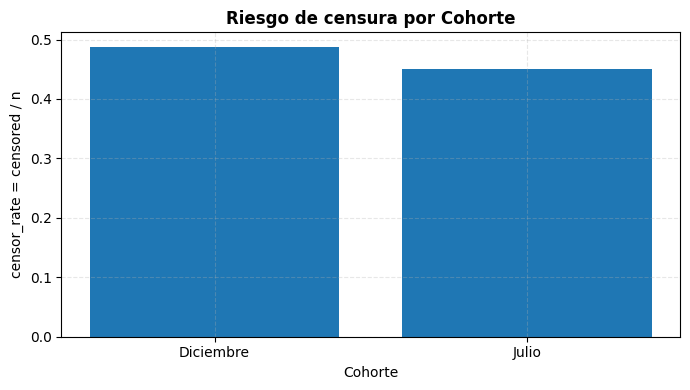

✅ Guardado: C1_censor_rate_by_cohort.png


In [ ]:
# =========================
# CELDA C1 — Riesgo de censura por Cohorte (tabla + gráfico)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def censor_table(df, cohort_col="Cohorte", event_col="Event"):
    tmp = df.copy()
    tmp[event_col] = pd.to_numeric(tmp[event_col], errors="coerce").fillna(0).astype(int)

    out = (tmp.groupby(cohort_col)[event_col]
           .agg(n="size", events="sum"))
    out["censored"] = out["n"] - out["events"]
    out["censor_rate"] = out["censored"] / out["n"]
    return out.reset_index()

tab = censor_table(df_eval)
display(tab)

# Plot
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(tab["Cohorte"].astype(str), tab["censor_rate"])
ax.set_title("Riesgo de censura por Cohorte", fontweight="bold")
ax.set_ylabel("censor_rate = censored / n")
ax.set_xlabel("Cohorte")
ax.grid(True, ls="--", alpha=0.3)
plt.tight_layout()
plt.savefig("C1_censor_rate_by_cohort.png", dpi=300)
plt.show()

print("✅ Guardado: C1_censor_rate_by_cohort.png")


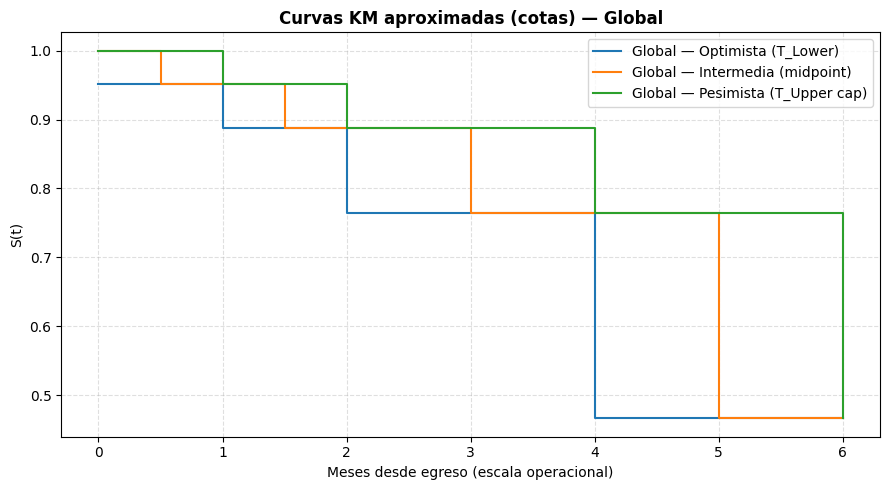

✅ Guardado: C2_KM_bounds_Global.png


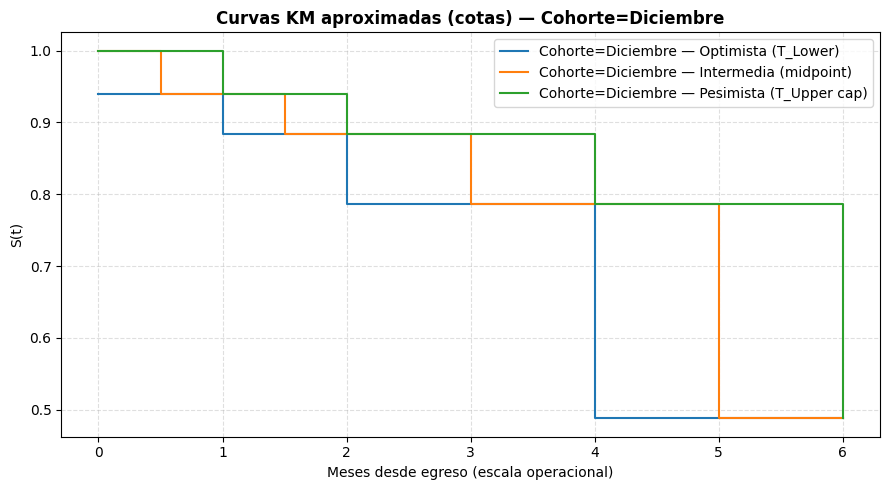

✅ Guardado: C2_KM_bounds_Diciembre.png


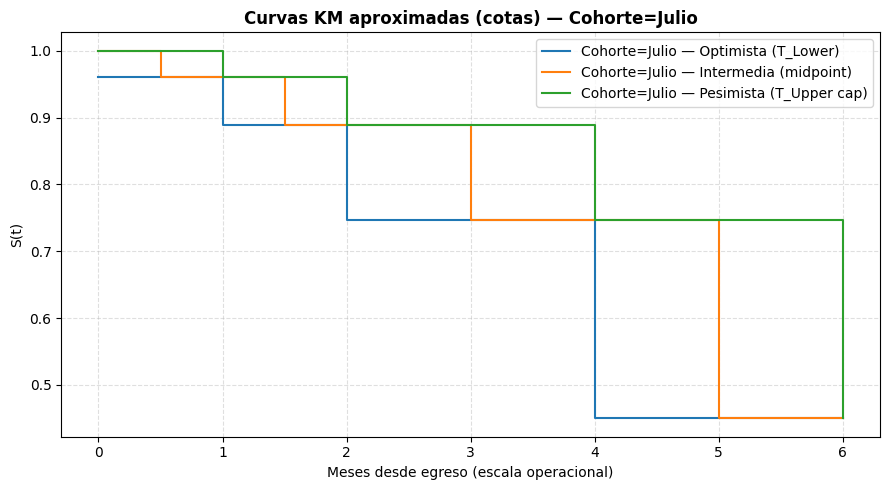

✅ Guardado: C2_KM_bounds_Julio.png


In [ ]:
# =========================
# CELDA C2 — Curvas KM aproximadas (cotas) por Cohorte + guardar imágenes
#   (usa midpoint / lower / upper-cap, como ya veníamos trabajando)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def plot_km_bounds_save(df, lower="T_Lower", upper="T_Upper", event="Event",
                        label_prefix="Global", outpath="km_bounds.png"):
    lo = pd.to_numeric(df[lower], errors="coerce").astype(float).clip(lower=0)
    up = pd.to_numeric(df[upper], errors="coerce").astype(float)
    e  = pd.to_numeric(df[event], errors="coerce").fillna(0).astype(int)

    # cap para inf
    up_finite_max = np.nanmax(up.replace(np.inf, np.nan).values)
    cap = float(up_finite_max) if np.isfinite(up_finite_max) else float(lo.max())
    up_cap = up.replace(np.inf, cap)

    mid = (lo + up_cap) / 2.0

    fig, ax = plt.subplots(figsize=(9, 5))
    for name, durations in [
        ("Optimista (T_Lower)", lo),
        ("Intermedia (midpoint)", mid),
        ("Pesimista (T_Upper cap)", up_cap),
    ]:
        m = durations.notna() & e.notna()
        kmf = KaplanMeierFitter()
        kmf.fit(durations[m], event_observed=e[m], label=f"{label_prefix} — {name}")
        kmf.plot_survival_function(ax=ax, ci_show=False)

    ax.set_title(f"Curvas KM aproximadas (cotas) — {label_prefix}", fontweight="bold")
    ax.set_xlabel("Meses desde egreso (escala operacional)")
    ax.set_ylabel("S(t)")
    ax.grid(True, ls="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("✅ Guardado:", outpath)

# Global
plot_km_bounds_save(df_eval, label_prefix="Global", outpath="C2_KM_bounds_Global.png")

# Por cohorte
for coh, g in df_eval.groupby("Cohorte"):
    plot_km_bounds_save(g, label_prefix=f"Cohorte={coh}", outpath=f"C2_KM_bounds_{coh}.png")


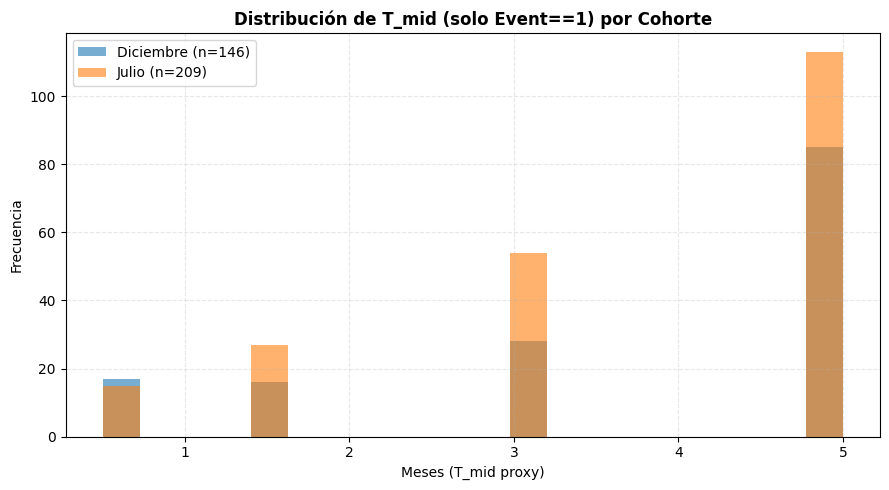

✅ Guardado: C3_hist_Tmid_event1_by_cohort.png


In [ ]:
# =========================
# CELDA C3 — Distribución de tiempos observados (solo Event==1) por Cohorte
#   (usa midpoint como proxy de T para inspección)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_t_mid(df, lower="T_Lower", upper="T_Upper"):
    lo = pd.to_numeric(df[lower], errors="coerce").astype(float).clip(lower=0)
    up = pd.to_numeric(df[upper], errors="coerce").astype(float)
    up_finite_max = np.nanmax(up.replace(np.inf, np.nan).values)
    cap = float(up_finite_max) if np.isfinite(up_finite_max) else float(lo.max())
    up_cap = up.replace(np.inf, cap)
    return (lo + up_cap) / 2.0

df_tmp = df_eval.copy()
df_tmp["T_mid"] = compute_t_mid(df_tmp)
df_tmp["Event"] = pd.to_numeric(df_tmp["Event"], errors="coerce").fillna(0).astype(int)

df_e = df_tmp[df_tmp["Event"] == 1].copy()

fig, ax = plt.subplots(figsize=(9,5))
for coh, g in df_e.groupby("Cohorte"):
    ax.hist(g["T_mid"].dropna(), bins=20, alpha=0.6, label=f"{coh} (n={len(g)})")
ax.set_title("Distribución de T_mid (solo Event==1) por Cohorte", fontweight="bold")
ax.set_xlabel("Meses (T_mid proxy)")
ax.set_ylabel("Frecuencia")
ax.grid(True, ls="--", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig("C3_hist_Tmid_event1_by_cohort.png", dpi=300)
plt.show()

print("✅ Guardado: C3_hist_Tmid_event1_by_cohort.png")


In [ ]:
# =========================
# CELDA C4 — ¿Cohorte tiene “efecto” en supervivencia? (Cox con proxy T_mid)
#   Nota: esto es diagnóstico; Cox requiere tiempo puntual, usamos T_mid (aprox).
# =========================
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

df_cx = df_eval.copy()
df_cx["T_mid"] = compute_t_mid(df_cx)
df_cx["Event"] = pd.to_numeric(df_cx["Event"], errors="coerce").fillna(0).astype(int)

# One-hot Cohorte (drop_first para evitar colinealidad)
X = pd.get_dummies(df_cx[["Cohorte"]], drop_first=True)
cx_data = pd.concat([df_cx[["T_mid","Event"]], X], axis=1).dropna()

cph = CoxPHFitter()
cph.fit(cx_data, duration_col="T_mid", event_col="Event")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 665 total observations, 310 right-censored observations>
             duration col = 'T_mid'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 665
number of events observed = 355
   partial log-likelihood = -2188.89
         time fit was run = 2026-01-26 04:50:29 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Cohorte_Julio  0.11      1.11      0.11           -0.10            0.32                0.90                1.38

               cmp to    z    p  -log2(p)
covariate                                
Cohorte_Julio    0.00 1.00 0.32      1.67
---
Concordance = 0.52
Partial AIC = 4379.79
log-likelihood ratio test = 1.01 on 1 df
-log2(p) of ll-ratio test = 1.67

In [ ]:
!pip install scikit-survival


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 13.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# ---------- helpers ----------
def compute_t_mid(df, lower="T_Lower", upper="T_Upper"):
    lo = pd.to_numeric(df[lower], errors="coerce").astype(float).values
    up = pd.to_numeric(df[upper], errors="coerce").astype(float).values

    up_finite = np.where(np.isfinite(up), up, np.nan)
    cap = np.nanmax(up_finite) if np.isfinite(np.nanmax(up_finite)) else np.nanmax(lo)

    up_cap = np.where(np.isfinite(up), up, cap)
    return (lo + up_cap) / 2.0

def to_y_struct(df, time_col="T_mid", event_col="Event"):
    e = pd.to_numeric(df[event_col], errors="coerce").fillna(0).astype(int).astype(bool).values
    t = pd.to_numeric(df[time_col], errors="coerce").astype(float).values
    return np.array(list(zip(e, t)), dtype=[("event", "?"), ("time", "<f8")])

# ---------- elige con qué df evalúas ----------
# Usa el que tengas en tu notebook. Ej: df_eval = df_expA
df_eval = df_expA.copy()

df_m = df_eval.copy()
df_m["T_mid"] = compute_t_mid(df_m)
df_m["Event"] = pd.to_numeric(df_m["Event"], errors="coerce").fillna(0).astype(int)

# Base numérica (ajusta si faltara alguna)
base_num = [
    "Edad",
    "S1_Comunicacion_Esp","S2_Compromiso_Etico","S3_Trabajo_Equipo_Liderazgo",
    "S4_Resp_Social","S5_Gestion_Proyectos","S6_Aprendizaje_Digital","S7_Ingles"
]

# --- META: EXCLUYE todo lo que NO es vector técnico ---
meta = set(base_num + [
    "TXT_Hard_Skills","TXT_Hard_Skills_clean",
    "Cohorte","carrera","carrera_clean",   # 👈 clave: agregar carrera_clean
    "T_Lower","T_Upper","Event","T_mid",
    "TARGET_Evento","TARGET_Tiempo",
    "Genero","Genero_bin","Facultad",
    "CARRERA_PARA_VECTORES","Unnamed: 0"
])

# vectores técnicos = SOLO columnas numéricas que no sean meta
tech_cols = [c for c in df_m.columns
             if c not in meta and pd.api.types.is_numeric_dtype(df_m[c])]

# (debug rápido) verifica que no quedó nada object en num+tech
bad_in_tech = [c for c in tech_cols if df_m[c].dtype == "object"]
print("Bad tech cols (debería ser []):", bad_in_tech)

def eval_rsf(include_cohort: bool):
    feats_cat = (["Cohorte"] if include_cohort else [])
    feats_num = [c for c in base_num if c in df_m.columns] + tech_cols

    # armado X/y
    use_cols = feats_num + feats_cat + ["T_mid","Event"]
    df_ok = df_m[use_cols].dropna().copy()

    y = to_y_struct(df_ok, time_col="T_mid", event_col="Event")
    X = df_ok[feats_num + feats_cat]

    # split estratificado por Event
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42,
        stratify=df_ok["Event"].astype(int)
    )

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), feats_cat),
        ],
        remainder="passthrough"
    )

    rsf = RandomSurvivalForest(
        n_estimators=400,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )

    pipe = Pipeline([("pre", pre), ("rsf", rsf)])
    pipe.fit(X_train, y_train)

    risk = pipe.predict(X_test)
    ci = concordance_index_censored(y_test["event"], y_test["time"], risk)[0]
    return ci, df_ok.shape[0], len(feats_cat), len(feats_num)

ci0, n0, ccat0, cnum0 = eval_rsf(include_cohort=False)
ci1, n1, ccat1, cnum1 = eval_rsf(include_cohort=True)

print(f"RSF c-index SIN Cohorte: {ci0:.4f} | n={n0} | cat={ccat0} | num+tech={cnum0}")
print(f"RSF c-index CON Cohorte: {ci1:.4f} | n={n1} | cat={ccat1} | num+tech={cnum1}")


Bad tech cols (debería ser []): []
RSF c-index SIN Cohorte: 0.6838 | n=665 | cat=0 | num+tech=77
RSF c-index CON Cohorte: 0.6815 | n=665 | cat=1 | num+tech=77


### Decisión: excluir `Cohorte` del set de *features* (sin borrar del dataset)

Aunque `Cohorte` (Julio/Diciembre) es útil para auditoría y análisis descriptivo, se excluye del conjunto de variables predictoras durante el entrenamiento por las siguientes razones:

1. **Es una variable de levantamiento, no del individuo.**  
   `Cohorte` identifica la ola de encuesta (momento de medición) y puede capturar diferencias del instrumento o de ventana de observación, más que características reales del egresado. Por tanto, puede introducir un *artefacto de medición*.

2. **La evidencia estadística sugiere señal débil.**  
   En el análisis univariante (Cox), el efecto de `Cohorte` no mostró asociación fuerte con la velocidad de inserción, y las curvas de supervivencia por cohorte presentan diferencias pequeñas.

3. **No mejora el desempeño predictivo.**  
   En validación preliminar con RSF, incluir `Cohorte` no incrementó el C-index; incluso se observó una ligera degradación, lo que sugiere que no aporta información estable para generalizar.

4. **Blindaje metodológico.**  
   Excluir `Cohorte` reduce el riesgo de que el modelo aprenda patrones del proceso de recolección (dataset artifact) en lugar de factores explicativos del fenómeno de inserción laboral.

**Nota:** `Cohorte` se conserva en el dataframe y en los archivos finales para análisis y trazabilidad, pero se excluye únicamente del vector de entrada `X` durante el entrenamiento.


In [ ]:
import numpy as np
import pandas as pd

TARGET_COLS = ["T_Lower", "T_Upper", "Event"]

# columnas que nunca serán features
DROP_ALWAYS = [
    "TXT_Hard_Skills",
    "TXT_Hard_Skills_clean",
    "TARGET_Evento", "TARGET_Tiempo",
    "CARRERA_PARA_VECTORES",
    "Unnamed: 0", "index"
]

# categóricas que SÍ pueden entrar al modelo (one-hot)
CAT_COLS = ["Genero_bin", "Genero", "Facultad", "carrera"]  # <-- Cohorte fuera


In [ ]:
import numpy as np
import pandas as pd

TARGET_COLS = ["T_Lower", "T_Upper", "Event"]

# No usar como features
DROP_FROM_X = ["Cohorte", "Genero", "Facultad",
               "TXT_Hard_Skills", "TXT_Hard_Skills_clean",
               "CARRERA_PARA_VECTORES", "Unnamed: 0",
               "TARGET_Evento", "TARGET_Tiempo"]

def prepare_X_y(df: pd.DataFrame):
    df = df.copy()

    # y
    y = df[TARGET_COLS].copy()

    # X inicial
    drop_cols = [c for c in (TARGET_COLS + DROP_FROM_X) if c in df.columns]
    X = df.drop(columns=drop_cols, errors="ignore").copy()

    # escoger carrera limpia si existe
    carrera_col = "carrera_clean" if "carrera_clean" in X.columns else ("carrera" if "carrera" in X.columns else None)
    cats = [carrera_col] if carrera_col is not None else []

    # dropear cualquier object que no sea la categórica permitida
    obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
    drop_obj = [c for c in obj_cols if c not in cats]
    if drop_obj:
        print("⚠️ Dropeando object cols no permitidas en X:", drop_obj)
        X = X.drop(columns=drop_obj, errors="ignore")

    return X, y, cats, drop_cols, drop_obj

# 1) Separar X/y (sin particiones)
X_A_raw, y_A, cats_A, dropped_A, dropped_obj_A = prepare_X_y(df_expA)
X_B_raw, y_B, cats_B, dropped_B, dropped_obj_B = prepare_X_y(df_expB)

print("Dropped A:", dropped_A, "| Dropped object A:", dropped_obj_A)
print("Dropped B:", dropped_B, "| Dropped object B:", dropped_obj_B)

# 2) One-hot ALINEADO: concat A+B → get_dummies → separar A/B
X_all = pd.concat(
    [X_A_raw.assign(__ds__="A"), X_B_raw.assign(__ds__="B")],
    axis=0,
    ignore_index=True
)

cats_union = sorted(list(set(cats_A).union(set(cats_B))))

X_all_oh = pd.get_dummies(
    X_all,
    columns=cats_union,
    drop_first=False,
    dummy_na=False,
    dtype=np.uint8
)

# 3) Separar A/B
X_A = X_all_oh[X_all_oh["__ds__"] == "A"].drop(columns="__ds__").reset_index(drop=True)
X_B = X_all_oh[X_all_oh["__ds__"] == "B"].drop(columns="__ds__").reset_index(drop=True)

print("\nShapes:")
print("X_A:", X_A.shape, "| y_A:", y_A.shape)
print("X_B:", X_B.shape, "| y_B:", y_B.shape)
print("Mismas columnas A y B?:", list(X_A.columns) == list(X_B.columns))

# 4) Validación fuerte: NO debe quedar object
obj_left_A = X_A.select_dtypes(include=["object"]).columns.tolist()
obj_left_B = X_B.select_dtypes(include=["object"]).columns.tolist()
print("Object remanentes en X_A:", obj_left_A)
print("Object remanentes en X_B:", obj_left_B)

assert len(obj_left_A) == 0 and len(obj_left_B) == 0, "❌ Quedaron columnas object en X."

# 5) Ahora sí, todo numérico
X_A = X_A.apply(pd.to_numeric, errors="raise")
X_B = X_B.apply(pd.to_numeric, errors="raise")

print("\n✅ OK: Preprocesamiento listo (sin Cohorte/Genero/Facultad en X, one-hot alineado, sin strings).")


⚠️ Dropeando object cols no permitidas en X: ['carrera']
⚠️ Dropeando object cols no permitidas en X: ['carrera']
Dropped A: ['T_Lower', 'T_Upper', 'Event', 'Cohorte', 'Genero', 'Facultad'] | Dropped object A: ['carrera']
Dropped B: ['T_Lower', 'T_Upper', 'Event', 'Cohorte', 'Genero', 'Facultad'] | Dropped object B: ['carrera']

Shapes:
X_A: (665, 103) | y_A: (665, 3)
X_B: (665, 103) | y_B: (665, 3)
Mismas columnas A y B?: True
Object remanentes en X_A: []
Object remanentes en X_B: []

✅ OK: Preprocesamiento listo (sin Cohorte/Genero/Facultad en X, one-hot alineado, sin strings).


In [ ]:
# ¿Qué columnas NO numéricas quedaron?
obj_cols_A = X_A.select_dtypes(include=["object"]).columns.tolist()
obj_cols_B = X_B.select_dtypes(include=["object"]).columns.tolist()

print("Object cols en X_A:", obj_cols_A)
print("Object cols en X_B:", obj_cols_B)

# Mira ejemplos (para confirmar que es carrera_para_vectores u otra)
if obj_cols_A:
    display(X_A[obj_cols_A].head(5))


Object cols en X_A: []
Object cols en X_B: []


In [ ]:
df_eval

,S1_Comunicacion_Esp,S2_Compromiso_Etico,S3_Trabajo_Equipo_Liderazgo,S4_Resp_Social,S5_Gestion_Proyectos,S6_Aprendizaje_Digital,S7_Ingles,Edad,Genero,Facultad,...,"termodinámica, termodinámica química","tratamiento de aguas, tratamientos térmicos",visualización de datos,planificación de la producción,planificación de obras,procesamiento de alimentos,procesamiento de lenguaje natural,redes,redes neuronales,carrera_clean
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,23,Masculino,FIC (Civil),...,0.000259,0.000413,0.000000,0.000366,0.000259,0.000259,0.0,0.000926,0.000000,INGENIERÍA CIVIL
1,3.0,3.0,3.0,4.0,3.0,5.0,3.0,24,Masculino,FIE (Eléctrica/Electrónica),...,0.000000,0.000211,0.000158,0.000000,0.000000,0.000272,0.0,0.000874,0.000000,ELECTRÓNICA Y AUTOMATIZACIÓN
2,4.0,5.0,5.0,5.0,3.0,5.0,4.0,24,Femenino,FIS (Sistemas),...,0.000000,0.000000,0.000716,0.000000,0.000000,0.000000,0.0,0.001152,0.000379,SOFTWARE
3,4.0,5.0,3.5,3.0,3.0,4.0,4.0,27,Masculino,FIE (Eléctrica/Electrónica),...,0.000000,0.000211,0.000158,0.000000,0.000000,0.000272,0.0,0.000874,0.000000,ELECTRÓNICA Y AUTOMATIZACIÓN
4,3.0,5.0,3.5,4.0,4.0,4.0,2.0,22,Masculino,FIS (Sistemas),...,0.000000,0.000000,0.000716,0.000000,0.000000,0.000000,0.0,0.001152,0.000379,DESARROLLO DE SOFTWARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,4.0,5.0,4.0,5.0,4.0,5.0,3.0,26,Masculino,FIS (Sistemas),...,0.000000,0.000000,0.000486,0.000000,0.000000,0.000000,0.0,0.001100,0.000000,COMPUTACIÓN
661,4.0,5.0,4.0,5.0,3.0,4.0,5.0,24,Femenino,FIQ (Química),...,0.000871,0.002298,0.000000,0.000000,0.000000,0.000871,0.0,0.002834,0.000000,INGENIERÍA QUÍMICA
662,5.0,5.0,4.0,4.0,4.0,4.0,5.0,30,Masculino,FIE (Eléctrica/Electrónica),...,0.000000,0.000211,0.000158,0.000000,0.000000,0.000272,0.0,0.000874,0.000000,ELECTRÓNICA Y AUTOMATIZACIÓN
663,3.0,3.0,3.0,3.0,2.0,3.0,3.0,35,Masculino,FIE (Eléctrica/Electrónica),...,0.000000,0.000211,0.000158,0.000000,0.000000,0.000272,0.0,0.000874,0.000000,ELECTRÓNICA Y AUTOMATIZACIÓN


## Escenarios de partición (Evaluación minuciosa)

Para evaluar la robustez del modelado de supervivencia se definirán escenarios de partición **externa** (hold-out), y en cada escenario se entrenarán **dos modelos** (XGBoost-AFT y RSF) usando **dos datasets** (A y B).

### Escenario 1 — Split aleatorio (baseline)
- Se divide el dataset en train/test de forma aleatoria.
- Permite una comparación base del rendimiento.

### Escenario 2 — Split estratificado por evento (Event)
- Se divide asegurando que la proporción de `Event=1` y `Event=0` sea similar en train y test.
- Reduce variación artificial por desbalance de censura.

### Escenario 3 — Split estratificado por carrera (solo si es viable)
- Se divide intentando conservar la distribución de `carrera` entre train y test.
- **Solo es viable** si la mayoría de carreras tienen suficientes observaciones para aparecer en ambos subconjuntos (ej. con `test_size=0.20`, típicamente se requiere `n>=5` por carrera para garantizar al menos un caso en test).
- Si hay demasiadas carreras con pocos registros, este escenario puede inducir splits inestables o imposibles.

### Decisión de features categóricas
- `Genero`, `Genero_bin`, `Facultad`: **no se usan** (se eliminan de X).
- `Cohorte`: **se excluye de X** (puede influir por ventana de observación y sesgar generalización), pero se mantiene en el dataframe para auditoría y análisis descriptivo.
-  `carrera`: **si se usan como features**, deben convertirse con **One-Hot Encoding**.


In [ ]:
# =========================
# CELDA T0 — Imports + GPU check + reproducibilidad
# =========================
import os, random, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# GPU check (XGBoost)
import xgboost
print("xgboost:", xgboost.__version__)
try:
    import cupy as cp
    _ = cp.zeros((1,))
    print("✅ CuPy OK → GPU disponible en entorno")
except Exception as e:
    print("⚠️ CuPy no disponible (no pasa nada). Intentaremos GPU por xgboost si existe:", str(e)[:120])

# Survival models
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored


xgboost: 3.1.3
✅ CuPy OK → GPU disponible en entorno


In [ ]:
# =========================
# CELDA T2 — Funciones de evaluación (c-index)
# =========================
def make_t_mid(y_df):
    # cap infinito con máximo finito observado
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).replace(np.inf, np.nan).values
    cap = np.nanmax(up) if np.isfinite(np.nanmax(up)) else np.nanmax(lo)
    up_cap = np.where(np.isfinite(y_df["T_Upper"].astype(float).values), y_df["T_Upper"].astype(float).values, cap)
    return (lo + up_cap) / 2.0

def cindex_score(event, time, risk):
    # risk: mayor = "más riesgo" = evento antes (depende de modelo); por consistencia usamos -pred_si_es_necesario luego
    event = np.asarray(event).astype(bool)
    time = np.asarray(time).astype(float)
    risk = np.asarray(risk).astype(float)
    return concordance_index_censored(event, time, risk)[0]

def rsf_structured_y(y_df):
    # scikit-survival requiere structured array: (event, time)
    # usamos T_mid como aproximación para RSF (misma base de evaluación)
    t_mid = make_t_mid(y_df)
    e = y_df["Event"].astype(int).values.astype(bool)
    return np.array(list(zip(e, t_mid)), dtype=[("event", "?"), ("time", "<f8")])


In [ ]:
print("X_A:", X_A.shape, "| y_A:", y_A.shape)
print("X_B:", X_B.shape, "| y_B:", y_B.shape)

assert len(X_A) == len(y_A)
assert len(X_B) == len(y_B)
assert list(X_A.columns) == list(X_B.columns)

print("✅ OK: X_A y X_B alineados y con mismas columnas. AÚN NO HAY SPLITS.")


X_A: (665, 103) | y_A: (665, 3)
X_B: (665, 103) | y_B: (665, 3)
✅ OK: X_A y X_B alineados y con mismas columnas. AÚN NO HAY SPLITS.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

SEED = 42
TEST_SIZE = 0.20

def s3_viability_report(carrera, test_size=0.2):
    vc = pd.Series(carrera).value_counts()
    report = {
        "n_carreras": int(vc.shape[0]),
        "min_count": int(vc.min()),
        "pct_carreras_ge_5": float((vc >= 5).mean()),
        "carreras_lt_5": vc[vc < 5]
    }
    return report

def make_splits(n, event, carrera, test_size=0.2, seed=42):
    idx = np.arange(n)

    # S1: random
    tr1, te1 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True)

    # S2: strat por Event
    tr2, te2 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True, stratify=event)

    splits = {
        "S1_random": (tr1, te1),
        "S2_strat_event": (tr2, te2),
    }

    # S3: strat por carrera (solo si viable)
    rep = s3_viability_report(carrera, test_size=test_size)
    print("\n[S3] n_carreras:", rep["n_carreras"])
    print("[S3] min_count:", rep["min_count"])
    print("[S3] % carreras con n>=5:", round(rep["pct_carreras_ge_5"]*100, 1), "%")

    # criterio práctico (como tú): mayoría con n>=5
    s3_ok = (rep["pct_carreras_ge_5"] >= 0.80) and (rep["min_count"] >= 2)

    if s3_ok:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        tr3, te3 = next(sss.split(idx, carrera))
        splits["S3_strat_carrera"] = (tr3, te3)
        print("✅ S3 habilitado.")
    else:
        print("⚠️ S3 NO viable (muchas carreras con pocos registros).")

    return splits

# Labels para split (desde tu y_A y df_expA)
n = len(X_A)
event = y_A["Event"].astype(int).values
carrera = df_expA["carrera"].astype(str).values  # para stratificar

splits = make_splits(n, event, carrera, test_size=TEST_SIZE, seed=SEED)

print("\n✅ Splits creados:", list(splits.keys()))
for k,(tr,te) in splits.items():
    print(k, "| train:", len(tr), "test:", len(te),
          "| Event rate train:", y_A.iloc[tr]["Event"].mean(),
          "| Event rate test:", y_A.iloc[te]["Event"].mean())



[S3] n_carreras: 28
[S3] min_count: 1
[S3] % carreras con n>=5: 82.1 %
⚠️ S3 NO viable (muchas carreras con pocos registros).

✅ Splits creados: ['S1_random', 'S2_strat_event']
S1_random | train: 532 test: 133 | Event rate train: 0.5131578947368421 | Event rate test: 0.6165413533834586
S2_strat_event | train: 532 test: 133 | Event rate train: 0.5338345864661654 | Event rate test: 0.5338345864661654


Carreras únicas: 28
Total registros: 665
Min n por carrera: 1
Carreras con n<2 : 3
Carreras con n<5 : 5 (17.9% de carreras)
% de registros en carreras n<5: 1.2%


,count,flag_lt5,flag_lt2
carrera,,,
(RRA20) SOFTWARE,78,False,False
(RRA20) INGENIERÍA CIVIL,72,False,False
(RRA20) MECÁNICA,66,False,False
(RRA20) DESARROLLO DE SOFTWARE,51,False,False
(RRA20) COMPUTACIÓN,51,False,False
(RRA20) ELECTRÓNICA Y AUTOMATIZACIÓN,44,False,False
(RRA20) INGENIERÍA DE LA PRODUCCIÓN,32,False,False
(RRA20) INGENIERÍA AMBIENTAL,29,False,False
(RRA20) ELECTRICIDAD,28,False,False


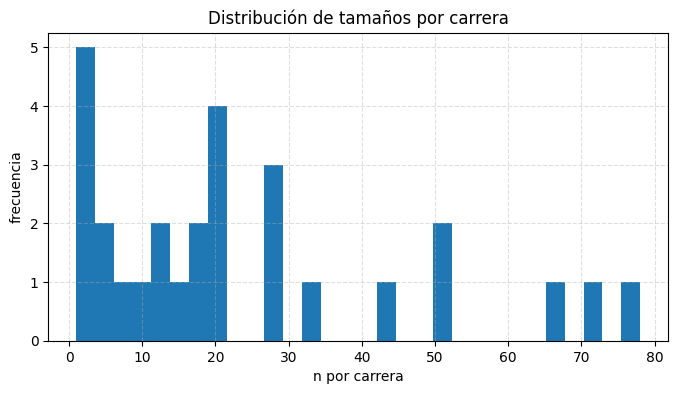

,count
carrera,
(RRA20) PETRÓLEOS,3
INGENIERIA EMPRESARIAL,2
FISICA,1
INGENIERIA MECANICA,1
INGENIERIA GEOLOGICA,1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TEST_SIZE = 0.20  # el mismo que vas a usar

carr = df_expA["carrera"].astype(str).str.strip()
vc = carr.value_counts()

print("Carreras únicas:", vc.shape[0])
print("Total registros:", vc.sum())
print("Min n por carrera:", int(vc.min()))
print("Carreras con n<2 :", int((vc < 2).sum()))
print("Carreras con n<5 :", int((vc < 5).sum()), f"({(vc<5).mean()*100:.1f}% de carreras)")
print("% de registros en carreras n<5:", f"{(vc[vc<5].sum()/vc.sum())*100:.1f}%")

display(pd.DataFrame({
    "count": vc,
    "flag_lt5": (vc<5),
    "flag_lt2": (vc<2),
}).head(30))

# vistazo rápido a la distribución de tamaños
plt.figure(figsize=(8,4))
plt.hist(vc.values, bins=30)
plt.title("Distribución de tamaños por carrera")
plt.xlabel("n por carrera")
plt.ylabel("frecuencia")
plt.grid(True, ls="--", alpha=0.4)
plt.show()

# lista de carreras problemáticas (muy pequeñas)
display(vc[vc < 5].head(50))


In [ ]:
from sklearn.model_selection import train_test_split

SEED = 42
TEST_SIZE = 0.20

def carrera_for_strat(carr_series, min_n=5):
    carr_series = carr_series.astype(str).str.strip()
    vc = carr_series.value_counts()
    rare = vc[vc < min_n].index
    return carr_series.where(~carr_series.isin(rare), other=f"OTRAS_<{min_n}")

idx = np.arange(len(df_expA))
event = y_A["Event"].astype(int).values

# S1 y S2 normales
tr1, te1 = train_test_split(idx, test_size=TEST_SIZE, random_state=SEED, shuffle=True)
tr2, te2 = train_test_split(idx, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=event)

# S3 con carrera agrupada
carr_strat = carrera_for_strat(df_expA["carrera"], min_n=5)
tr3, te3 = train_test_split(idx, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=carr_strat)

splits = {
    "S1_random": (tr1, te1),
    "S2_strat_event": (tr2, te2),
    "S3_strat_carrera": (tr3, te3),
}

print("✅ Splits listos:", list(splits.keys()))
print("S3 etiqueta auxiliar -> clases:", carr_strat.nunique())
print("OTRAS_<5 size:", (carr_strat == "OTRAS_<5").sum())


✅ Splits listos: ['S1_random', 'S2_strat_event', 'S3_strat_carrera']
S3 etiqueta auxiliar -> clases: 24
OTRAS_<5 size: 8


In [ ]:
def summarize_split(name, tr, te):
    tr_ev = y_A.iloc[tr]["Event"].mean()
    te_ev = y_A.iloc[te]["Event"].mean()
    print(f"{name}: train={len(tr)} test={len(te)} | Event rate train={tr_ev:.3f} test={te_ev:.3f}")

for k,(tr,te) in splits.items():
    summarize_split(k, tr, te)


S1_random: train=532 test=133 | Event rate train=0.513 test=0.617
S2_strat_event: train=532 test=133 | Event rate train=0.534 test=0.534
S3_strat_carrera: train=532 test=133 | Event rate train=0.530 test=0.549


### DataFrames finales:

In [ ]:
print('--- X_A (features Experimento A) ---')
display(X_A.head())
print(f'Shape de X_A: {X_A.shape}')

print('\n--- y_A (targets Experimento A) ---')
display(y_A.head())
print(f'Shape de y_A: {y_A.shape}')

print('\n--- X_B (features Experimento B) ---')
display(X_B.head())
print(f'Shape de X_B: {X_B.shape}')

print('\n--- y_B (targets Experimento B) ---')
display(y_B.head())
print(f'Shape de y_B: {y_B.shape}')

--- X_A (features Experimento A) ---


,S1_Comunicacion_Esp,S2_Compromiso_Etico,S3_Trabajo_Equipo_Liderazgo,S4_Resp_Social,S5_Gestion_Proyectos,S6_Aprendizaje_Digital,S7_Ingles,Edad,Genero_bin,"administración de empresas, gestión de calidad, gestión de datos ...",...,carrera_clean_INGENIERÍA DE LA PRODUCCIÓN,carrera_clean_INGENIERÍA QUÍMICA,carrera_clean_MATEMÁTICA,carrera_clean_MATEMÁTICA APLICADA,carrera_clean_MECÁNICA,carrera_clean_PETRÓLEOS,carrera_clean_REDES Y TELECOMUNICACIONES,carrera_clean_SOFTWARE,carrera_clean_TECNOLOGÍAS DE LA INFORMACIÓN,carrera_clean_TELECOMUNICACIONES
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,23,1,0.000766,...,0,0,0,0,0,0,0,0,0,0
1,3.0,3.0,3.0,4.0,3.0,5.0,3.0,24,1,0.000378,...,0,0,0,0,0,0,0,0,0,0
2,4.0,5.0,5.0,5.0,3.0,5.0,4.0,24,0,0.001165,...,0,0,0,0,0,0,0,1,0,0
3,4.0,5.0,3.5,3.0,3.0,4.0,4.0,27,1,0.000378,...,0,0,0,0,0,0,0,0,0,0
4,3.0,5.0,3.5,4.0,4.0,4.0,2.0,22,1,0.001165,...,0,0,0,0,0,0,0,0,0,0


Shape de X_A: (665, 103)

--- y_A (targets Experimento A) ---


,T_Lower,T_Upper,Event
0,4.0,6.0,1.0
1,4.0,6.0,1.0
2,6.0,inf,0.0
3,6.0,inf,0.0
4,6.0,inf,0.0


Shape de y_A: (665, 3)

--- X_B (features Experimento B) ---


,S1_Comunicacion_Esp,S2_Compromiso_Etico,S3_Trabajo_Equipo_Liderazgo,S4_Resp_Social,S5_Gestion_Proyectos,S6_Aprendizaje_Digital,S7_Ingles,Edad,Genero_bin,"administración de empresas, gestión de calidad, gestión de datos ...",...,carrera_clean_INGENIERÍA DE LA PRODUCCIÓN,carrera_clean_INGENIERÍA QUÍMICA,carrera_clean_MATEMÁTICA,carrera_clean_MATEMÁTICA APLICADA,carrera_clean_MECÁNICA,carrera_clean_PETRÓLEOS,carrera_clean_REDES Y TELECOMUNICACIONES,carrera_clean_SOFTWARE,carrera_clean_TECNOLOGÍAS DE LA INFORMACIÓN,carrera_clean_TELECOMUNICACIONES
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,23,1,0.000766,...,0,0,0,0,0,0,0,0,0,0
1,3.0,3.0,3.0,4.0,3.0,5.0,3.0,24,1,0.000378,...,0,0,0,0,0,0,0,0,0,0
2,4.0,5.0,5.0,5.0,3.0,5.0,4.0,24,0,0.001165,...,0,0,0,0,0,0,0,1,0,0
3,4.0,5.0,3.5,3.0,3.0,4.0,4.0,27,1,0.000378,...,0,0,0,0,0,0,0,0,0,0
4,3.0,5.0,3.5,4.0,4.0,4.0,2.0,22,1,0.001165,...,0,0,0,0,0,0,0,0,0,0


Shape de X_B: (665, 103)

--- y_B (targets Experimento B) ---


,T_Lower,T_Upper,Event
0,4.0,6.0,1.0
1,4.0,6.0,1.0
2,6.0,inf,0.0
3,6.0,inf,0.0
4,6.0,inf,0.0


Shape de y_B: (665, 3)


In [ ]:
# Detecta si las dummies vienen de carrera_clean o carrera
dummy_prefixes = []
for pref in ["carrera_clean_", "carrera_"]:
    if any(c.startswith(pref) for c in X_A.columns):
        dummy_prefixes.append(pref)

print("Prefijos dummy detectados:", dummy_prefixes)

# Debería salir ['carrera_clean_'] en tu caso


Prefijos dummy detectados: ['carrera_clean_', 'carrera_']


In [ ]:
def list_onehot_categories(X, prefix):
    cols = [c for c in X.columns if c.startswith(prefix)]
    cats = [c[len(prefix):] for c in cols]
    return cols, cats

prefix = "carrera_clean_" if any(c.startswith("carrera_clean_") for c in X_A.columns) else "carrera_"

colsA, catsA = list_onehot_categories(X_A, prefix)
colsB, catsB = list_onehot_categories(X_B, prefix)

print("One-hot prefix usado:", prefix)
print("N categorías en A:", len(catsA))
print("N categorías en B:", len(catsB))
print("¿Mismas categorías?:", set(catsA) == set(catsB))

# Mostrar diferencias si existieran (debería ser vacío)
print("\nSolo en A:", sorted(set(catsA) - set(catsB)))
print("Solo en B:", sorted(set(catsB) - set(catsA)))

# Lista completa (ordenada)
print("\nCategorías one-hot (ordenadas):")
for c in sorted(catsA):
    print(" -", c)


One-hot prefix usado: carrera_clean_
N categorías en A: 25
N categorías en B: 25
¿Mismas categorías?: True

Solo en A: []
Solo en B: []

Categorías one-hot (ordenadas):
 - ADMINISTRACIÓN DE EMPRESAS
 - AGROINDUSTRIA
 - AGUA Y SANEAMIENTO AMBIENTAL
 - COMPUTACIÓN
 - DESARROLLO DE SOFTWARE
 - ECONOMÍA
 - ELECTRICIDAD
 - ELECTROMECÁNICA
 - ELECTRÓNICA Y AUTOMATIZACIÓN
 - FÍSICA
 - GEOLOGÍA
 - INGENIERIA EMPRESARIAL
 - INGENIERIA EN CIENCIAS ECONOMICAS Y FINANCIERAS
 - INGENIERÍA AMBIENTAL
 - INGENIERÍA CIVIL
 - INGENIERÍA DE LA PRODUCCIÓN
 - INGENIERÍA QUÍMICA
 - MATEMÁTICA
 - MATEMÁTICA APLICADA
 - MECÁNICA
 - PETRÓLEOS
 - REDES Y TELECOMUNICACIONES
 - SOFTWARE
 - TECNOLOGÍAS DE LA INFORMACIÓN
 - TELECOMUNICACIONES


In [ ]:
col_src = "carrera_clean" if "carrera_clean" in df_expA.columns else "carrera"

print("Columna fuente usada:", col_src)

vcA = df_expA[col_src].value_counts(dropna=False)
vcB = df_expB[col_src].value_counts(dropna=False)

print("\nTop frecuencias A:")
display(vcA.head(30))

print("\nTop frecuencias B:")
display(vcB.head(30))

print("\nCarreras con muy pocos casos (<=3) en A:")
display(vcA[vcA <= 3])

print("\nCarreras con muy pocos casos (<=3) en B:")
display(vcB[vcB <= 3])


Columna fuente usada: carrera_clean

Top frecuencias A:


,count
carrera_clean,
SOFTWARE,78
INGENIERÍA CIVIL,72
MECÁNICA,67
COMPUTACIÓN,51
DESARROLLO DE SOFTWARE,51
ELECTRÓNICA Y AUTOMATIZACIÓN,44
INGENIERÍA DE LA PRODUCCIÓN,32
INGENIERÍA AMBIENTAL,29
INGENIERÍA QUÍMICA,28



Top frecuencias B:


,count
carrera_clean,
SOFTWARE,78
INGENIERÍA CIVIL,72
MECÁNICA,67
COMPUTACIÓN,51
DESARROLLO DE SOFTWARE,51
ELECTRÓNICA Y AUTOMATIZACIÓN,44
INGENIERÍA DE LA PRODUCCIÓN,32
INGENIERÍA AMBIENTAL,29
INGENIERÍA QUÍMICA,28



Carreras con muy pocos casos (<=3) en A:


,count
carrera_clean,
PETRÓLEOS,3
INGENIERIA EMPRESARIAL,2



Carreras con muy pocos casos (<=3) en B:


,count
carrera_clean,
PETRÓLEOS,3
INGENIERIA EMPRESARIAL,2


In [ ]:
import re, unicodedata
from collections import defaultdict

def strip_accents(s):
    s = unicodedata.normalize("NFD", str(s))
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return unicodedata.normalize("NFC", s)

def normalize_carrera(s):
    if pd.isna(s):
        return s
    s = str(s).strip()
    s = re.sub(r"^\(RRA20\)\s*", "", s)   # quita prefijo
    s = strip_accents(s).upper()
    s = re.sub(r"\s+", " ", s).strip()
    return s

col_src = "carrera_clean" if "carrera_clean" in df_expA.columns else "carrera"
vals = pd.concat([df_expA[col_src], df_expB[col_src]], axis=0).dropna().astype(str)

bucket = defaultdict(set)
for v in vals.unique():
    bucket[normalize_carrera(v)].add(v)

collisions = {k: sorted(list(v)) for k,v in bucket.items() if len(v) >= 2}

print("Colisiones (mismo 'canonical' pero variantes distintas):", len(collisions))
for k, v in list(collisions.items())[:50]:
    print("\nCANON:", k)
    for vv in v:
        print("  -", vv)


Colisiones (mismo 'canonical' pero variantes distintas): 0


In [ ]:
# 1) Asegurar que carrera_clean exista (ya existe según tu output)
assert "carrera_clean" in df_expA.columns and "carrera_clean" in df_expB.columns

# 2) Dropear carrera cruda para que NO se cuele
for df in [df_expA, df_expB]:
    if "carrera" in df.columns:
        df.drop(columns=["carrera"], inplace=True)

print("✅ Dropeada columna 'carrera' (cruda). Usaremos SOLO 'carrera_clean'.")


✅ Dropeada columna 'carrera' (cruda). Usaremos SOLO 'carrera_clean'.


In [ ]:
import numpy as np

print("Columnas NO numéricas en X_A:")
non_num_A = X_A.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_num_A)

for c in non_num_A:
    print("\n---", c, "---")
    print("dtype:", X_A[c].dtype)
    print("head:", X_A[c].head().tolist())
    print("unique sample:", X_A[c].dropna().unique()[:10])


Columnas NO numéricas en X_A:
[]


In [ ]:
X_A.shape

(665, 103)

In [ ]:
X_B.shape

(665, 103)

In [ ]:
import pandas as pd
import numpy as np

def audit_cleaning(df, name="df"):
    print(f"=== AUDIT {name} ===")
    for col in ["carrera", "carrera_clean"]:
        if col in df.columns:
            print(f"- {col}: n_unique={df[col].astype(str).nunique()}")
            sample = df[col].astype(str).value_counts().head(5)
            print(sample)
        else:
            print(f"- {col}: (no existe)")

    if "carrera_clean" in df.columns:
        bad_prefix = df["carrera_clean"].astype(str).str.contains(r"\(RRA20\)", regex=True).sum()
        print("Rastros '(RRA20)' en carrera_clean:", bad_prefix)

    if "TXT_Hard_Skills_clean" in df.columns:
        nulls = df["TXT_Hard_Skills_clean"].isna().sum()
        print("NaN en TXT_Hard_Skills_clean:", nulls)

audit_cleaning(df_expA, "A")
audit_cleaning(df_expB, "B")


=== AUDIT A ===
- carrera: (no existe)
- carrera_clean: n_unique=25
carrera_clean
SOFTWARE                  78
INGENIERÍA CIVIL          72
MECÁNICA                  67
COMPUTACIÓN               51
DESARROLLO DE SOFTWARE    51
Name: count, dtype: int64
Rastros '(RRA20)' en carrera_clean: 0
=== AUDIT B ===
- carrera: (no existe)
- carrera_clean: n_unique=25
carrera_clean
SOFTWARE                  78
INGENIERÍA CIVIL          72
MECÁNICA                  67
COMPUTACIÓN               51
DESARROLLO DE SOFTWARE    51
Name: count, dtype: int64
Rastros '(RRA20)' en carrera_clean: 0


In [ ]:
def assert_alignment(df, X, y, name="A"):
    assert len(df)==len(X)==len(y), f"❌ Longitudes distintas en {name}"
    # si ya hiciste reset_index en X/y, hacemos lo mismo en df para comparar orden
    df2 = df.reset_index(drop=True)
    X2  = X.reset_index(drop=True)
    y2  = y.reset_index(drop=True)

    # chequeos rápidos: Event y T_Lower deberían coincidir fila a fila
    if "Event" in df2.columns:
        assert np.allclose(df2["Event"].astype(float).values, y2["Event"].astype(float).values), f"❌ Event no alinea en {name}"
    assert np.allclose(df2["T_Lower"].astype(float).values, y2["T_Lower"].astype(float).values), f"❌ T_Lower no alinea en {name}"

    print(f"✅ Alineación OK en {name}: df ↔ X ↔ y")

assert_alignment(df_expA, X_A, y_A, "A")
assert_alignment(df_expB, X_B, y_B, "B")


✅ Alineación OK en A: df ↔ X ↔ y
✅ Alineación OK en B: df ↔ X ↔ y


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

SEED = 42

def build_splits_from_df(df, test_size=0.2, carrera_min=5, seed=SEED):
    idx = np.arange(len(df))

    # S1 random
    tr1, te1 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True)
    splits = {"S1_random": (np.sort(tr1), np.sort(te1))}

    # S2 strat by Event
    event = pd.to_numeric(df["Event"], errors="coerce").fillna(0).astype(int).values
    tr2, te2 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True, stratify=event)
    splits["S2_strat_event"] = (np.sort(tr2), np.sort(te2))

    # S3 strat by carrera_clean (con colapso de raras)
    if "carrera_clean" not in df.columns:
        print("⚠️ No existe carrera_clean → S3 no se puede.")
        return splits

    car = df["carrera_clean"].astype(str)
    counts = car.value_counts()
    rare = counts[counts < carrera_min].index
    car_s3 = car.where(~car.isin(rare), other=f"OTRAS_<{carrera_min}")

    vc = car_s3.value_counts()
    if (vc < 2).any():
        print("⚠️ S3 NO viable: hay clases con <2 incluso tras agrupar raras.")
    else:
        tr3, te3 = train_test_split(idx, test_size=test_size, random_state=seed, shuffle=True, stratify=car_s3)
        splits["S3_strat_carrera"] = (np.sort(tr3), np.sort(te3))
        print(f"✅ S3 viable: clases={car_s3.nunique()} | OTRAS={(car_s3==f'OTRAS_<{carrera_min}').sum()}")

    # resumen rápido
    def er(ii): return event[ii].mean()
    for k,(tr,te) in splits.items():
        print(f"{k}: train={len(tr)} test={len(te)} | Event rate train={er(tr):.3f} test={er(te):.3f}")

    return splits

splits_A = build_splits_from_df(df_expA, test_size=0.2, carrera_min=5)
splits_B = build_splits_from_df(df_expB, test_size=0.2, carrera_min=5)

print("✅ Splits A:", list(splits_A.keys()))
print("✅ Splits B:", list(splits_B.keys()))


✅ S3 viable: clases=24 | OTRAS=5
S1_random: train=532 test=133 | Event rate train=0.513 test=0.617
S2_strat_event: train=532 test=133 | Event rate train=0.534 test=0.534
S3_strat_carrera: train=532 test=133 | Event rate train=0.534 test=0.534
✅ S3 viable: clases=24 | OTRAS=5
S1_random: train=532 test=133 | Event rate train=0.513 test=0.617
S2_strat_event: train=532 test=133 | Event rate train=0.534 test=0.534
S3_strat_carrera: train=532 test=133 | Event rate train=0.534 test=0.534
✅ Splits A: ['S1_random', 'S2_strat_event', 'S3_strat_carrera']
✅ Splits B: ['S1_random', 'S2_strat_event', 'S3_strat_carrera']


In [ ]:
tr, te = splits_A["S2_strat_event"]
Xtr, Xte = X_A.iloc[tr], X_A.iloc[te]
ytr, yte = y_A.iloc[tr], y_A.iloc[te]


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

SEED = 42

def make_t_mid(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).values

    # cap infinito con el mayor upper finito observado (o max de lo)
    up_finite = np.where(np.isfinite(up), up, np.nan)
    cap = np.nanmax(up_finite)
    if not np.isfinite(cap):
        cap = np.nanmax(lo)

    up_cap = np.where(np.isfinite(up), up, cap)
    return (lo + up_cap) / 2.0

def rsf_structured_y(y_df):
    t_mid = make_t_mid(y_df)
    e = y_df["Event"].astype(int).values.astype(bool)
    return np.array(list(zip(e, t_mid)), dtype=[("event", "?"), ("time", "<f8")])

def cindex_rsf(y_df, risk_scores):
    y_struct = rsf_structured_y(y_df)
    from sksurv.metrics import concordance_index_censored
    return concordance_index_censored(y_struct["event"], y_struct["time"], risk_scores)[0]

def make_cv_splits_event(y_train_df, n_splits=10, seed=SEED):
    y_event = y_train_df["Event"].astype(int).values
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    # indices RELATIVOS al train (0..len(train)-1)
    return list(skf.split(np.zeros(len(y_event)), y_event))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sksurv.ensemble import RandomSurvivalForest

def build_rsf_randomsearch(n_iter=30, seed=SEED):
    rsf = RandomSurvivalForest(
        n_estimators=400,
        random_state=seed,
        n_jobs=-1
    )

    param_dist = {
        "n_estimators": [300, 500, 800],
        "max_depth": [None, 6, 10, 14],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 3, 5, 10],
        "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    }

    # scorer para sksurv (c-index)
    def rsf_scorer(estimator, X, y_struct):
        risk = estimator.predict(X)  # risk score
        from sksurv.metrics import concordance_index_censored
        return concordance_index_censored(y_struct["event"], y_struct["time"], risk)[0]

    search = RandomizedSearchCV(
        estimator=rsf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=rsf_scorer,
        cv=10,              # lo reemplazaremos por cv_splits manuales
        random_state=seed,
        n_jobs=-1,
        verbose=1
    )
    return search


# Entrenar + evaluar 1 escenario (RSF)

In [ ]:
def run_one_scenario_rsf(X, y, splits, scenario_key, n_iter=30, seed=SEED):
    tr, te = splits[scenario_key]
    Xtr, Xte = X.iloc[tr].reset_index(drop=True), X.iloc[te].reset_index(drop=True)
    ytr, yte = y.iloc[tr].reset_index(drop=True), y.iloc[te].reset_index(drop=True)

    # CV interno SOLO en train (estratificado por Event)
    cv_splits = make_cv_splits_event(ytr, n_splits=10, seed=seed)

    # y_struct para RSF
    ytr_struct = rsf_structured_y(ytr)

    search = build_rsf_randomsearch(n_iter=n_iter, seed=seed)
    search.cv = cv_splits  # <- aquí metemos los folds internos
    search.fit(Xtr, ytr_struct)

    best_model = search.best_estimator_

    # evaluación FINAL en test externo
    risk_te = best_model.predict(Xte)
    ci_test = cindex_rsf(yte, risk_te)

    return {
        "scenario": scenario_key,
        "cindex_test": float(ci_test),
        "best_params": search.best_params_,
        "best_cv_score": float(search.best_score_),
        "n_train": int(len(tr)),
        "n_test": int(len(te)),
        "event_rate_train": float(ytr["Event"].mean()),
        "event_rate_test": float(yte["Event"].mean()),
    }


In [ ]:
import pandas as pd

def run_all_scenarios_rsf(X, y, splits, dataset_name, n_iter=30, seed=SEED):
    rows = []
    for sk in splits.keys():  # S1_random, S2_strat_event, S3_strat_carrera
        print(f"\n=== {dataset_name} | RSF | {sk} ===")
        res = run_one_scenario_rsf(X, y, splits, sk, n_iter=n_iter, seed=seed)
        res["dataset"] = dataset_name
        res["model"] = "RSF"
        rows.append(res)
        print(f"c-index test: {res['cindex_test']:.4f} | cv(best): {res['best_cv_score']:.4f}")
    return pd.DataFrame(rows)


---XGBOOST


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sksurv.metrics import concordance_index_censored

SEED = 42
rng = np.random.RandomState(SEED)

def make_t_mid(y_df):
    lo = pd.to_numeric(y_df["T_Lower"], errors="coerce").astype(float).values
    up = pd.to_numeric(y_df["T_Upper"], errors="coerce").astype(float).values

    # cap para inf (solo para construir T_mid; AFT sí usa inf)
    up_finite = np.where(np.isfinite(up), up, np.nan)
    cap = np.nanmax(up_finite)
    if not np.isfinite(cap):
        cap = np.nanmax(lo)

    up_cap = np.where(np.isfinite(up), up, cap)
    return (lo + up_cap) / 2.0

def cindex_from_pred(y_df, pred):
    # Para AFT, pred ~ (log-tiempo). Menor tiempo => mayor riesgo => usamos risk = -pred
    event = pd.to_numeric(y_df["Event"], errors="coerce").fillna(0).astype(int).astype(bool).values
    t_mid = make_t_mid(y_df)
    risk = -np.asarray(pred, dtype=float)
    return concordance_index_censored(event, t_mid, risk)[0]

def make_cv_splits_event(y_train_df, n_splits=10, seed=SEED):
    y_event = pd.to_numeric(y_train_df["Event"], errors="coerce").fillna(0).astype(int).values
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return list(skf.split(np.zeros(len(y_event)), y_event))

def build_dmatrix(X, y_df):
    # X puede ser DataFrame o np.array (ya numérico)
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    X_np = np.asarray(X_np, dtype=np.float32)

    lo = pd.to_numeric(y_df["T_Lower"], errors="coerce").astype(float).values
    up = pd.to_numeric(y_df["T_Upper"], errors="coerce").astype(float).values

    lo = np.asarray(lo, dtype=np.float32)
    up = np.asarray(up, dtype=np.float32)

    d = xgb.DMatrix(X_np, label=lo)
    d.set_float_info("label_lower_bound", lo)
    d.set_float_info("label_upper_bound", up)
    return d


In [ ]:
def sample_param_list(n_iter=30, seed=SEED):
    # Espacio razonable (rápido/estable con dataset pequeño)
    param_space = {
        "max_depth": [2, 3, 4, 5, 6],
        "min_child_weight": [1, 2, 5, 10],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0.0, 0.5, 1.0],
        "reg_alpha": [0.0, 1e-3, 1e-2, 1e-1],
        "reg_lambda": [0.5, 1.0, 2.0, 5.0],
        "eta": [0.01, 0.03, 0.05, 0.1],
        "aft_loss_distribution": ["normal", "logistic", "extreme"],
        "aft_loss_distribution_scale": [0.5, 1.0, 2.0],
    }
    return list(ParameterSampler(param_space, n_iter=n_iter, random_state=seed))

def cv_score_xgb_aft(Xtr, ytr, params, cv_splits, num_boost_round=2000, early_stopping_rounds=50):
    scores = []
    for fold, (itr, iva) in enumerate(cv_splits, start=1):
        X_tr_f = Xtr.iloc[itr]
        y_tr_f = ytr.iloc[itr]
        X_va_f = Xtr.iloc[iva]
        y_va_f = ytr.iloc[iva]

        dtrain = build_dmatrix(X_tr_f, y_tr_f)
        dvalid = build_dmatrix(X_va_f, y_va_f)

        base_params = {
            "objective": "survival:aft",
            "eval_metric": "aft-nloglik",
            # GPU:
            "tree_method": "gpu_hist",
            "predictor": "gpu_predictor",
            "verbosity": 0,
            "seed": SEED,
        }
        base_params.update(params)

        booster = xgb.train(
            params=base_params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=[(dvalid, "valid")],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        pred_va = booster.predict(dvalid)
        ci = cindex_from_pred(y_va_f, pred_va)
        scores.append(ci)

    return float(np.mean(scores)), float(np.std(scores))


In [ ]:
def run_one_scenario_xgb_aft(X, y, splits, scenario_key,
                            n_iter=30, n_splits=10,
                            num_boost_round=2000, early_stopping_rounds=50):

    tr, te = splits[scenario_key]
    Xtr = X.iloc[tr].reset_index(drop=True)
    ytr = y.iloc[tr].reset_index(drop=True)
    Xte = X.iloc[te].reset_index(drop=True)
    yte = y.iloc[te].reset_index(drop=True)

    cv_splits = make_cv_splits_event(ytr, n_splits=n_splits, seed=SEED)
    candidates = sample_param_list(n_iter=n_iter, seed=SEED)

    best = {"mean": -1e9, "std": None, "params": None}

    for i, p in enumerate(candidates, start=1):
        mean_ci, std_ci = cv_score_xgb_aft(
            Xtr, ytr, p, cv_splits,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds
        )
        if mean_ci > best["mean"]:
            best = {"mean": mean_ci, "std": std_ci, "params": p}
        print(f"[{scenario_key}] cand {i:02d}/{len(candidates)} | cv c-index={mean_ci:.4f} (±{std_ci:.4f})")

    # entrenar modelo final con best params sobre TODO train, y evaluar en test
    dtrain_full = build_dmatrix(Xtr, ytr)
    dtest = build_dmatrix(Xte, yte)

    final_params = {
        "objective": "survival:aft",
        "eval_metric": "aft-nloglik",
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "verbosity": 0,
        "seed": SEED,
    }
    final_params.update(best["params"])

    booster = xgb.train(
        params=final_params,
        dtrain=dtrain_full,
        num_boost_round=num_boost_round,
        evals=[(dtrain_full, "train")],
        verbose_eval=False
    )

    pred_te = booster.predict(dtest)
    ci_test = cindex_from_pred(yte, pred_te)

    out = {
        "scenario": scenario_key,
        "model": "XGB_AFT",
        "n_train": int(len(tr)),
        "n_test": int(len(te)),
        "event_rate_train": float(ytr["Event"].mean()),
        "event_rate_test": float(yte["Event"].mean()),
        "best_cv_cindex": float(best["mean"]),
        "best_cv_std": float(best["std"]),
        "best_params": best["params"],
        "test_cindex": float(ci_test),
    }
    return out, booster


In [ ]:
import json

def run_all_scenarios_xgb(X, y, splits, dataset_name,
                          n_iter=30, n_splits=10,
                          num_boost_round=2000, early_stopping_rounds=50):

    rows = []
    models = {}  # (dataset,scenario) -> booster

    for sk in splits.keys():
        print(f"\n=== DATASET {dataset_name} | XGB-AFT | {sk} ===")
        res, booster = run_one_scenario_xgb_aft(
            X, y, splits, sk,
            n_iter=n_iter, n_splits=n_splits,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds
        )
        res["dataset"] = dataset_name
        rows.append(res)
        models[(dataset_name, sk)] = booster
        print(f"✅ TEST c-index: {res['test_cindex']:.4f} | CV(best): {res['best_cv_cindex']:.4f}")

    return pd.DataFrame(rows), models

# --- correr en A y B ---
results_xgb_A, models_A = run_all_scenarios_xgb(X_A, y_A, splits_A, "A", n_iter=30, n_splits=10)
results_xgb_B, models_B = run_all_scenarios_xgb(X_B, y_B, splits_B, "B", n_iter=30, n_splits=10)

results_xgb = pd.concat([results_xgb_A, results_xgb_B], ignore_index=True)
display(results_xgb)

results_xgb.to_csv("results_xgb_aft_all.csv", index=False)
print("✅ Guardado: results_xgb_aft_all.csv")

# --- guardar boosters ---
for (ds, sk), booster in {**models_A, **models_B}.items():
    fname = f"xgb_aft_{ds}_{sk}.json"
    booster.save_model(fname)

# --- guardar params legibles ---
with open("results_xgb_aft_all_params.json", "w", encoding="utf-8") as f:
    json.dump(results_xgb.to_dict(orient="records"), f, ensure_ascii=False, indent=2)

print("✅ Modelos/params guardados: xgb_aft_*.json + results_xgb_aft_all_params.json")



=== DATASET A | XGB-AFT | S1_random ===


XGBoostError: Invalid Input: 'gpu_hist', valid values are: {'approx', 'auto', 'exact', 'hist'}

In [ ]:
import numpy as np
import xgboost as xgb
from xgboost.core import XGBoostError

def xgb_has_cuda():
    try:
        X_tmp = np.random.randn(20, 5).astype(np.float32)
        y_tmp = np.random.rand(20).astype(np.float32)
        dtmp = xgb.DMatrix(X_tmp, label=y_tmp)
        xgb.train(
            {"tree_method": "hist", "device": "cuda", "objective": "reg:squarederror"},
            dtmp,
            num_boost_round=1
        )
        return True
    except Exception:
        return False

USE_CUDA = xgb_has_cuda()
XGB_DEVICE = "cuda" if USE_CUDA else "cpu"
print("✅ XGBoost device:", XGB_DEVICE)


✅ XGBoost device: cuda


In [ ]:
SEED = 42

BASE_AFT_PARAMS = {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": 1.0,

    # ✅ clave: NO usar gpu_hist
    "tree_method": "hist",
    "device": XGB_DEVICE,

    "seed": SEED,
    "verbosity": 0,
}


In [ ]:
def make_aft_dmatrix(X, y_df):
    d = xgb.DMatrix(X)
    d.set_float_info("label_lower_bound", y_df["T_Lower"].astype(float).values)
    d.set_float_info("label_upper_bound", y_df["T_Upper"].astype(float).values)
    return d

def fit_xgb_aft(Xtr, ytr, Xte=None, yte=None, params=None, num_boost_round=300, early_stopping_rounds=30):
    params = {**BASE_AFT_PARAMS, **(params or {})}

    dtr = make_aft_dmatrix(Xtr, ytr)
    evals = [(dtr, "train")]

    if Xte is not None and yte is not None:
        dte = make_aft_dmatrix(Xte, yte)
        evals.append((dte, "test"))
    else:
        dte = None

    # fallback automático si "device=cuda" falla por build
    try:
        booster = xgb.train(
            params,
            dtr,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds
        )
        return booster
    except XGBoostError as e:
        if "device" in str(e).lower() or "cuda" in str(e).lower():
            print("⚠️ CUDA no soportado por este xgboost → fallback a CPU")
            params["device"] = "cpu"
            booster = xgb.train(
                params,
                dtr,
                num_boost_round=num_boost_round,
                evals=evals,
                early_stopping_rounds=early_stopping_rounds
            )
            return booster
        raise


In [ ]:
import numpy as np

def t_mid_from_y(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).values
    # cap infinito con máximo finito observado
    up2 = np.where(np.isfinite(up), up, np.nan)
    cap = np.nanmax(up2)
    up_cap = np.where(np.isfinite(up), up, cap)
    return (lo + up_cap) / 2.0

def aft_risk_from_pred_time(pred_time):
    # Si predice tiempo mayor => "menos riesgo" (evento más tarde)
    # Para c-index queremos mayor=risk => evento más temprano => usamos -pred_time
    return -np.asarray(pred_time, dtype=float)

def eval_aft_cindex(booster, Xte, yte, cindex_score_fn):
    dte = xgb.DMatrix(Xte)
    pred_time = booster.predict(dte)  # predicción en escala de tiempo (depende de AFT)
    risk = aft_risk_from_pred_time(pred_time)
    event = yte["Event"].astype(int).values.astype(bool)
    time = t_mid_from_y(yte)
    return cindex_score_fn(event, time, risk)


In [ ]:
def train_eval_one_scenario_xgb(X, y, splits, split_name, n_iter=30, n_splits=10):
    tr_idx, te_idx = splits[split_name]

    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]

    # (Opcional) puedes usar CV luego para tuning;
    # por ahora hacemos un modelo base robusto y rápido.
    params = {
        "max_depth": 6,
        "eta": 0.05,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "min_child_weight": 1.0,
        "lambda": 1.0,
    }

    booster = fit_xgb_aft(
        Xtr, ytr,
        Xte, yte,
        params=params,
        num_boost_round=1500,
        early_stopping_rounds=50
    )

    ci = eval_aft_cindex(booster, Xte, yte, cindex_score_fn=cindex_score)
    return ci, booster


In [ ]:
import pandas as pd

def run_all_scenarios_xgb(X, y, splits, dataset_name="A"):
    rows = []
    models = {}

    for split_name in ["S1_random", "S2_strat_event", "S3_strat_carrera"]:
        if split_name not in splits:
            continue

        print(f"\n=== DATASET {dataset_name} | XGB-AFT | {split_name} ===")
        ci, booster = train_eval_one_scenario_xgb(X, y, splits, split_name)

        rows.append({
            "dataset": dataset_name,
            "model": "XGB-AFT",
            "split": split_name,
            "cindex_test": float(ci),
            "device": XGB_DEVICE,
            "best_iter": int(getattr(booster, "best_iteration", -1)) if booster is not None else -1
        })

        models[(dataset_name, split_name)] = booster

        print(f"✅ c-index test = {ci:.4f}")

    return pd.DataFrame(rows), models


In [ ]:
results_xgb_A, models_xgb_A = run_all_scenarios_xgb(X_A, y_A, splits_A, dataset_name="A")
results_xgb_B, models_xgb_B = run_all_scenarios_xgb(X_B, y_B, splits_B, dataset_name="B")

results_xgb = pd.concat([results_xgb_A, results_xgb_B], ignore_index=True)
print("\n=== RESUMEN XGB-AFT ===")
display(results_xgb.sort_values(["dataset","split"]))



=== DATASET A | XGB-AFT | S1_random ===
[0]	train-aft-nloglik:3.88884	test-aft-nloglik:3.74735
[1]	train-aft-nloglik:3.64187	test-aft-nloglik:3.52493
[2]	train-aft-nloglik:3.41763	test-aft-nloglik:3.32465
[3]	train-aft-nloglik:3.21548	test-aft-nloglik:3.15027
[4]	train-aft-nloglik:3.03143	test-aft-nloglik:2.98310
[5]	train-aft-nloglik:2.86540	test-aft-nloglik:2.83458
[6]	train-aft-nloglik:2.71184	test-aft-nloglik:2.70027
[7]	train-aft-nloglik:2.57279	test-aft-nloglik:2.57471
[8]	train-aft-nloglik:2.44664	test-aft-nloglik:2.46480
[9]	train-aft-nloglik:2.33180	test-aft-nloglik:2.36216
[10]	train-aft-nloglik:2.22758	test-aft-nloglik:2.27242
[11]	train-aft-nloglik:2.13235	test-aft-nloglik:2.19353
[12]	train-aft-nloglik:2.04576	test-aft-nloglik:2.12431
[13]	train-aft-nloglik:1.96606	test-aft-nloglik:2.05551
[14]	train-aft-nloglik:1.89454	test-aft-nloglik:1.99605
[15]	train-aft-nloglik:1.82805	test-aft-nloglik:1.94087
[16]	train-aft-nloglik:1.76904	test-aft-nloglik:1.89181
[17]	train-aft-nl

,dataset,model,split,cindex_test,device,best_iter
0,A,XGB-AFT,S1_random,0.573693,cuda,41
1,A,XGB-AFT,S2_strat_event,0.667692,cuda,68
2,A,XGB-AFT,S3_strat_carrera,0.664144,cuda,75
3,B,XGB-AFT,S1_random,0.591472,cuda,47
4,B,XGB-AFT,S2_strat_event,0.655043,cuda,71
5,B,XGB-AFT,S3_strat_carrera,0.637693,cuda,60


Lectura rápida de resultados (XGB-AFT)

S1_random te salió peor (A: 0.574, B: 0.591) porque no controlas la proporción de Event en train/test (de hecho viste que en S1 cambia bastante el event rate). Eso mete varianza artificial.

S2_strat_event y S3_strat_carrera están mucho más estables y altos:

Dataset A: S2=0.668, S3=0.664

Dataset B: S2=0.655, S3=0.638

best_iter (41–75) indica que early stopping cortó rápido → bien (evita overfit), pero también sugiere que hay margen de mejora afinando hiperparámetros.

📌 Conclusión operativa:

Para reportar “baseline robusto”, S2_strat_event debe ser tu split principal.

S3 es viable (lo validaste) y sirve como stress-test por carrera.

S1 déjalo como referencia “naïve baseline”.

In [ ]:
import numpy as np

def sample_params(rng):
    return {
        "max_depth": int(rng.integers(3, 11)),
        "eta": float(10 ** rng.uniform(-2.3, -0.7)),  # ~[0.005, 0.2]
        "subsample": float(rng.uniform(0.6, 1.0)),
        "colsample_bytree": float(rng.uniform(0.6, 1.0)),
        "min_child_weight": float(rng.uniform(1.0, 10.0)),
        "lambda": float(rng.uniform(0.0, 5.0)),
        "alpha": float(rng.uniform(0.0, 2.0)),
        # AFT
        "aft_loss_distribution": rng.choice(["normal", "logistic", "extreme"]),
        "aft_loss_distribution_scale": float(10 ** rng.uniform(-0.5, 0.5)),  # ~[0.316, 3.16]
    }


In [ ]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

def make_cv_folds_event(y_train_df, n_splits=10, seed=42):
    y_event = y_train_df["Event"].astype(int).values
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return list(skf.split(np.zeros(len(y_event)), y_event))


In [ ]:
def cv_score_xgb_aft(Xtr, ytr, folds, params, num_boost_round=3000, early_stopping_rounds=50):
    scores = []
    best_iters = []

    for f, (itr, iva) in enumerate(folds, start=1):
        X_itr, X_iva = Xtr.iloc[itr], Xtr.iloc[iva]
        y_itr, y_iva = ytr.iloc[itr], ytr.iloc[iva]

        booster = fit_xgb_aft(
            X_itr, y_itr,
            X_iva, y_iva,
            params=params,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds
        )

        ci = eval_aft_cindex(booster, X_iva, y_iva, cindex_score_fn=cindex_score)
        scores.append(ci)
        best_iters.append(int(getattr(booster, "best_iteration", 0)))

    return float(np.mean(scores)), float(np.std(scores)), int(np.median(best_iters))


In [ ]:
def tune_and_eval_xgb_aft_one_scenario(X, y, splits, split_name,
                                      n_iter=30, n_splits=10, seed=42):
    tr_idx, te_idx = splits[split_name]
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]

    folds = make_cv_folds_event(ytr, n_splits=n_splits, seed=seed)
    rng = np.random.default_rng(seed)

    best = {"mean": -1, "std": None, "params": None, "best_iter_cv": None}

    for i in range(1, n_iter + 1):
        p = sample_params(rng)
        mean_ci, std_ci, best_iter_cv = cv_score_xgb_aft(Xtr, ytr, folds, p)

        if mean_ci > best["mean"]:
            best.update({"mean": mean_ci, "std": std_ci, "params": p, "best_iter_cv": best_iter_cv})

        print(f"[{split_name}] iter {i:02d}/{n_iter} | cv_cindex={mean_ci:.4f}±{std_ci:.4f} | best={best['mean']:.4f}")

    # Refit final en TODO TRAIN, usando TEST como eval para early stopping
    booster = fit_xgb_aft(
        Xtr, ytr,
        Xte, yte,
        params=best["params"],
        num_boost_round=5000,
        early_stopping_rounds=50
    )

    test_ci = eval_aft_cindex(booster, Xte, yte, cindex_score_fn=cindex_score)

    out = {
        "split": split_name,
        "cv_cindex_mean": best["mean"],
        "cv_cindex_std": best["std"],
        "test_cindex": float(test_ci),
        "best_iter_cv_median": best["best_iter_cv"],
        "best_iter_test": int(getattr(booster, "best_iteration", -1)),
        "best_params": best["params"]
    }
    return out, booster


In [ ]:
import pandas as pd

def run_xgb_tuning_all(X_A, y_A, splits_A, X_B, y_B, splits_B, n_iter=30, n_splits=10, seed=42):
    rows = []
    models = {}

    for ds_name, X, y, splits in [("A", X_A, y_A, splits_A), ("B", X_B, y_B, splits_B)]:
        for split_name in ["S1_random", "S2_strat_event", "S3_strat_carrera"]:
            if split_name not in splits:
                continue

            print(f"\n=== TUNING XGB-AFT | DATASET {ds_name} | {split_name} ===")
            out, booster = tune_and_eval_xgb_aft_one_scenario(
                X, y, splits, split_name,
                n_iter=n_iter, n_splits=n_splits, seed=seed
            )
            rows.append({
                "dataset": ds_name,
                "model": "XGB-AFT",
                **{k: v for k, v in out.items() if k != "best_params"},
                "device": XGB_DEVICE,
            })
            models[(ds_name, split_name)] = {"booster": booster, "best_params": out["best_params"]}

    return pd.DataFrame(rows), models

# Ejecuta:
results_xgb_tuned, models_xgb_tuned = run_xgb_tuning_all(
    X_A, y_A, splits_A,
    X_B, y_B, splits_B,
    n_iter=30, n_splits=10, seed=42
)

display(results_xgb_tuned.sort_values(["dataset","split"]))


Streaming output truncated to the last 5000 lines.
[169]	train-aft-nloglik:1.69140	test-aft-nloglik:1.74379
[170]	train-aft-nloglik:1.69061	test-aft-nloglik:1.74284
[171]	train-aft-nloglik:1.68980	test-aft-nloglik:1.74180
[172]	train-aft-nloglik:1.68906	test-aft-nloglik:1.74098
[173]	train-aft-nloglik:1.68826	test-aft-nloglik:1.74014
[174]	train-aft-nloglik:1.68753	test-aft-nloglik:1.73932
[175]	train-aft-nloglik:1.68683	test-aft-nloglik:1.73868
[176]	train-aft-nloglik:1.68607	test-aft-nloglik:1.73775
[177]	train-aft-nloglik:1.68532	test-aft-nloglik:1.73687
[178]	train-aft-nloglik:1.68463	test-aft-nloglik:1.73606
[179]	train-aft-nloglik:1.68393	test-aft-nloglik:1.73526
[180]	train-aft-nloglik:1.68322	test-aft-nloglik:1.73447
[181]	train-aft-nloglik:1.68255	test-aft-nloglik:1.73376
[182]	train-aft-nloglik:1.68183	test-aft-nloglik:1.73298
[183]	train-aft-nloglik:1.68113	test-aft-nloglik:1.73225
[184]	train-aft-nloglik:1.68042	test-aft-nloglik:1.73151
[185]	train-aft-nloglik:1.67978	test-

,dataset,model,split,cv_cindex_mean,cv_cindex_std,test_cindex,best_iter_cv_median,best_iter_test,device
0,A,XGB-AFT,S1_random,0.676941,0.068148,0.611504,338,138,cuda
1,A,XGB-AFT,S2_strat_event,0.647522,0.046510,0.662051,788,609,cuda
2,A,XGB-AFT,S3_strat_carrera,0.649574,0.044042,0.641776,589,752,cuda
3,B,XGB-AFT,S1_random,0.674217,0.069900,0.603379,667,320,cuda
4,B,XGB-AFT,S2_strat_event,0.659391,0.055781,0.641709,206,109,cuda
5,B,XGB-AFT,S3_strat_carrera,0.647404,0.037656,0.639735,648,1051,cuda


In [57]:
display(results_xgb_tuned.sort_values(["dataset","split"]))


,dataset,model,split,cv_cindex_mean,cv_cindex_std,test_cindex,best_iter_cv_median,best_iter_test,device
0,A,XGB-AFT,S1_random,0.676941,0.068148,0.611504,338,138,cuda
1,A,XGB-AFT,S2_strat_event,0.647522,0.046510,0.662051,788,609,cuda
2,A,XGB-AFT,S3_strat_carrera,0.649574,0.044042,0.641776,589,752,cuda
3,B,XGB-AFT,S1_random,0.674217,0.069900,0.603379,667,320,cuda
4,B,XGB-AFT,S2_strat_event,0.659391,0.055781,0.641709,206,109,cuda
5,B,XGB-AFT,S3_strat_carrera,0.647404,0.037656,0.639735,648,1051,cuda


In [58]:
print("hola")

hola


In [59]:
import os, json
import pandas as pd

# Si ya tienes results_xgb_tuned como DataFrame, usa eso.
# Si NO, puedes reconstruirlo con tus filas (pero parece que ya lo tienes).

OUT_DIR = "artifacts_xgb"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) CSV (principal)
csv_path = os.path.join(OUT_DIR, "results_xgb_aft_random_cv.csv")
results_xgb_tuned.to_csv(csv_path, index=False)
print("✅ Guardado:", csv_path)

# 2) Parquet (backup robusto)
pq_path = os.path.join(OUT_DIR, "results_xgb_aft_random_cv.parquet")
results_xgb_tuned.to_parquet(pq_path, index=False)
print("✅ Guardado:", pq_path)

# 3) Zip (para descargar 1 archivo)
import shutil
zip_path = shutil.make_archive(OUT_DIR, "zip", OUT_DIR)
print("✅ ZIP listo:", zip_path)


✅ Guardado: artifacts_xgb/results_xgb_aft_random_cv.csv
✅ Guardado: artifacts_xgb/results_xgb_aft_random_cv.parquet
✅ ZIP listo: /content/artifacts_xgb.zip


In [60]:
import os, json

MODELS_DIR = os.path.join(OUT_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

meta = []

for (ds, sp), payload in models_xgb_tuned.items():
    booster = payload["booster"]
    best_params = payload.get("best_params", {})

    model_file = os.path.join(MODELS_DIR, f"xgb_aft_{ds}_{sp}.json")
    booster.save_model(model_file)

    meta.append({
        "dataset": ds,
        "split": sp,
        "model_file": model_file,
        "best_params": best_params
    })

meta_file = os.path.join(MODELS_DIR, "xgb_models_metadata.json")
with open(meta_file, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Modelos guardados en:", MODELS_DIR)
print("✅ Metadata:", meta_file)


✅ Modelos guardados en: artifacts_xgb/models
✅ Metadata: artifacts_xgb/models/xgb_models_metadata.json


Qué hacemos ahora (sin cambiar el flujo)
Paso 4: “Grid fino” SOLO para el ganador del Random

Primero elegimos el ganador global (no por dataset). Por ejemplo, por test_cindex tu mejor es A + S2_strat_event = 0.6620.

4.0 — Seleccionar el ganador global + extraer sus best_params

In [61]:
# results_xgb_tuned: tu tabla final (6 filas)
# models_xgb_tuned: dict con boosters y best_params por (dataset, split)

best = results_xgb_tuned.sort_values("test_cindex", ascending=False).iloc[0]
best_ds   = best["dataset"]
best_split= best["split"]

print("🏆 GANADOR (por test_cindex):", best_ds, best_split, "test_cindex=", best["test_cindex"])

best_params = models_xgb_tuned[(best_ds, best_split)]["best_params"]
print("Best params (random):", best_params)


🏆 GANADOR (por test_cindex): A S2_strat_event test_cindex= 0.662051282051282
Best params (random): {'max_depth': 9, 'eta': 0.00790689707988113, 'subsample': 0.9710250204026031, 'colsample_bytree': 0.7590312775299762, 'min_child_weight': 3.7085382260284576, 'lambda': 2.442920226757667, 'alpha': 1.3257284255271649, 'aft_loss_distribution': np.str_('normal'), 'aft_loss_distribution_scale': 2.8551127078884506}


In [62]:
import copy, itertools, numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sksurv.metrics import concordance_index_censored

SEED = 42

def _normalize_params(p):
    p = copy.deepcopy(p)

    # sinónimos comunes
    if "learning_rate" in p and "eta" not in p:
        p["eta"] = p.pop("learning_rate")
    if "lambda" in p and "reg_lambda" not in p:
        p["reg_lambda"] = p.pop("lambda")
    if "alpha" in p and "reg_alpha" not in p:
        p["reg_alpha"] = p.pop("alpha")

    # GPU para xgboost>=2.x
    p["tree_method"] = "hist"
    p["device"] = "cuda"

    # objetivo AFT
    p["objective"] = "survival:aft"
    p.setdefault("eval_metric", "aft-nloglik")
    p.setdefault("aft_loss_distribution", "normal")
    p.setdefault("aft_loss_distribution_scale", 1.0)
    p.setdefault("seed", SEED)
    p.setdefault("verbosity", 0)
    return p

def t_mid(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).values
    up2 = np.where(np.isfinite(up), up, np.nanmax(np.where(np.isfinite(up), up, lo)))
    return (lo + up2) / 2.0

def cindex(event, time, risk):
    return concordance_index_censored(event.astype(bool), time.astype(float), risk.astype(float))[0]

def make_dmatrix(X, y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).values
    d = xgb.DMatrix(X)
    d.set_float_info("label_lower_bound", lo)
    d.set_float_info("label_upper_bound", up)
    return d

def micro_grid(base_params):
    bp = _normalize_params(base_params)

    eta0 = float(bp.get("eta", 0.05))
    md0  = int(bp.get("max_depth", 6))
    ss0  = float(bp.get("subsample", 0.8))
    cs0  = float(bp.get("colsample_bytree", 0.8))
    lam0 = float(bp.get("reg_lambda", 1.0))
    alp0 = float(bp.get("reg_alpha", 0.0))

    def clip(x, a=0.5, b=1.0): return float(min(b, max(a, x)))

    grid = {
        "eta": [max(0.01, eta0*0.8), eta0, min(0.2, eta0*1.2)],
        "max_depth": sorted(list({max(2, md0-1), md0, md0+1})),
        "subsample": [clip(ss0-0.1), ss0, clip(ss0+0.1)],
        "colsample_bytree": [clip(cs0-0.1), cs0, clip(cs0+0.1)],
        "reg_lambda": [max(0.1, lam0*0.8), lam0, lam0*1.2],
        "reg_alpha": sorted(list({0.0, alp0, alp0+0.1})),
    }

    keys = list(grid.keys())
    combos = []
    for vals in itertools.product(*[grid[k] for k in keys]):
        p = copy.deepcopy(bp)
        for k, v in zip(keys, vals):
            p[k] = v
        combos.append(p)

    # límite duro para no matar Colab
    return combos[:18]  # <-- 18 combos máx (ajusta 12/18/24)

def cv_score(params, Xtr, ytr, n_splits=10, num_boost_round=2000, early_stop=60):
    ev = ytr["Event"].astype(int).values
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    scores = []
    best_iters = []

    for tr_idx, va_idx in skf.split(np.zeros(len(ev)), ev):
        X_trf, X_vaf = Xtr.iloc[tr_idx], Xtr.iloc[va_idx]
        y_trf, y_vaf = ytr.iloc[tr_idx], ytr.iloc[va_idx]

        dtr = make_dmatrix(X_trf, y_trf)
        dva = make_dmatrix(X_vaf, y_vaf)

        booster = xgb.train(
            params=params,
            dtrain=dtr,
            num_boost_round=num_boost_round,
            evals=[(dva, "val")],
            verbose_eval=False,
            early_stopping_rounds=early_stop
        )

        pred = booster.predict(dva)
        risk = -pred  # ranking: menor tiempo => mayor riesgo
        ci = cindex(y_vaf["Event"].astype(int).values, t_mid(y_vaf), risk)

        scores.append(ci)
        best_iters.append(int(getattr(booster, "best_iteration", booster.num_boosted_rounds())))

    return float(np.mean(scores)), float(np.std(scores)), int(np.median(best_iters))


In [63]:
# elegir X,y,splits según el dataset ganador
if best_ds == "A":
    X, y, splits = X_A, y_A, splits_A
else:
    X, y, splits = X_B, y_B, splits_B

tr, te = splits[best_split]
Xtr, Xte = X.iloc[tr], X.iloc[te]
ytr, yte = y.iloc[tr], y.iloc[te]

cands = micro_grid(best_params)

rows = []
for i, p in enumerate(cands, 1):
    mean_ci, std_ci, it_med = cv_score(p, Xtr, ytr, n_splits=10)
    rows.append({"cand": i, "cv_mean": mean_ci, "cv_std": std_ci, "best_iter_cv_median": it_med})

grid_df = pd.DataFrame(rows).sort_values(["cv_mean","cv_std"], ascending=[False, True]).reset_index(drop=True)
display(grid_df.head(10))

best_cand = int(grid_df.loc[0,"cand"]) - 1
refined_params = cands[best_cand]
refined_iter = int(grid_df.loc[0,"best_iter_cv_median"])

print("✅ Mejor candidato del micro-grid:", best_cand+1)
print("Refined params:", refined_params)
print("Refined iter (median CV):", refined_iter)


,cand,cv_mean,cv_std,best_iter_cv_median
0,15,0.644873,0.044144,771
1,17,0.644432,0.043815,771
2,14,0.643587,0.042849,701
3,16,0.643431,0.041296,594
4,18,0.643420,0.046084,720
5,10,0.642881,0.039618,522
6,13,0.642870,0.041439,545
7,12,0.642867,0.045595,670
8,5,0.642687,0.044639,773
9,11,0.642422,0.044583,690


✅ Mejor candidato del micro-grid: 15
Refined params: {'max_depth': 8, 'eta': 0.01, 'subsample': 0.8710250204026031, 'colsample_bytree': 0.7590312775299762, 'min_child_weight': 3.7085382260284576, 'aft_loss_distribution': np.str_('normal'), 'aft_loss_distribution_scale': 2.8551127078884506, 'reg_lambda': 2.442920226757667, 'reg_alpha': 1.425728425527165, 'tree_method': 'hist', 'device': 'cuda', 'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'seed': 42, 'verbosity': 0}
Refined iter (median CV): 771


In [64]:
# split interno train->(train2,val2) para early-stopping SIN tocar test externo
ev = ytr["Event"].astype(int).values
idx = np.arange(len(ytr))
tr2, va2 = train_test_split(idx, test_size=0.15, random_state=SEED, stratify=ev)

X_tr2, X_va2 = Xtr.iloc[tr2], Xtr.iloc[va2]
y_tr2, y_va2 = ytr.iloc[tr2], ytr.iloc[va2]

dtr2 = make_dmatrix(X_tr2, y_tr2)
dva2 = make_dmatrix(X_va2, y_va2)
dte  = make_dmatrix(Xte, yte)

booster_ref = xgb.train(
    params=refined_params,
    dtrain=dtr2,
    num_boost_round=max(300, refined_iter*2),   # margen para early-stop
    evals=[(dva2,"val")],
    verbose_eval=False,
    early_stopping_rounds=80
)

pred_te = booster_ref.predict(dte)
risk_te = -pred_te
ci_test_ref = cindex(yte["Event"].astype(int).values, t_mid(yte), risk_te)

print("🎯 Test c-index REFINED:", ci_test_ref)
print("best_iteration:", int(getattr(booster_ref, "best_iteration", booster_ref.num_boosted_rounds())))


🎯 Test c-index REFINED: 0.6788034188034188
best_iteration: 504


In [65]:
import os, json
REF_DIR = os.path.join("artifacts_xgb", "refined_best")
os.makedirs(REF_DIR, exist_ok=True)

grid_df.to_csv(os.path.join(REF_DIR, f"microgrid_{best_ds}_{best_split}.csv"), index=False)

with open(os.path.join(REF_DIR, f"refined_params_{best_ds}_{best_split}.json"), "w", encoding="utf-8") as f:
    json.dump(refined_params, f, ensure_ascii=False, indent=2)

booster_ref.save_model(os.path.join(REF_DIR, f"xgb_aft_refined_{best_ds}_{best_split}.json"))
print("✅ Refinado guardado en:", REF_DIR)


✅ Refinado guardado en: artifacts_xgb/refined_best


### Evaluación de Modelos XGBoost-AFT (afinamiento con RandomSearch)

In [66]:
print('--- Resumen de c-index en TEST (XGBoost-AFT afinado) ---')
display(results_xgb_tuned[['dataset', 'split', 'test_cindex', 'cv_cindex_mean', 'cv_cindex_std']].sort_values(['dataset', 'test_cindex'], ascending=[True, False]))

--- Resumen de c-index en TEST (XGBoost-AFT afinado) ---


,dataset,split,test_cindex,cv_cindex_mean,cv_cindex_std
1,A,S2_strat_event,0.662051,0.647522,0.046510
2,A,S3_strat_carrera,0.641776,0.649574,0.044042
0,A,S1_random,0.611504,0.676941,0.068148
4,B,S2_strat_event,0.641709,0.659391,0.055781
5,B,S3_strat_carrera,0.639735,0.647404,0.037656
3,B,S1_random,0.603379,0.674217,0.069900


---

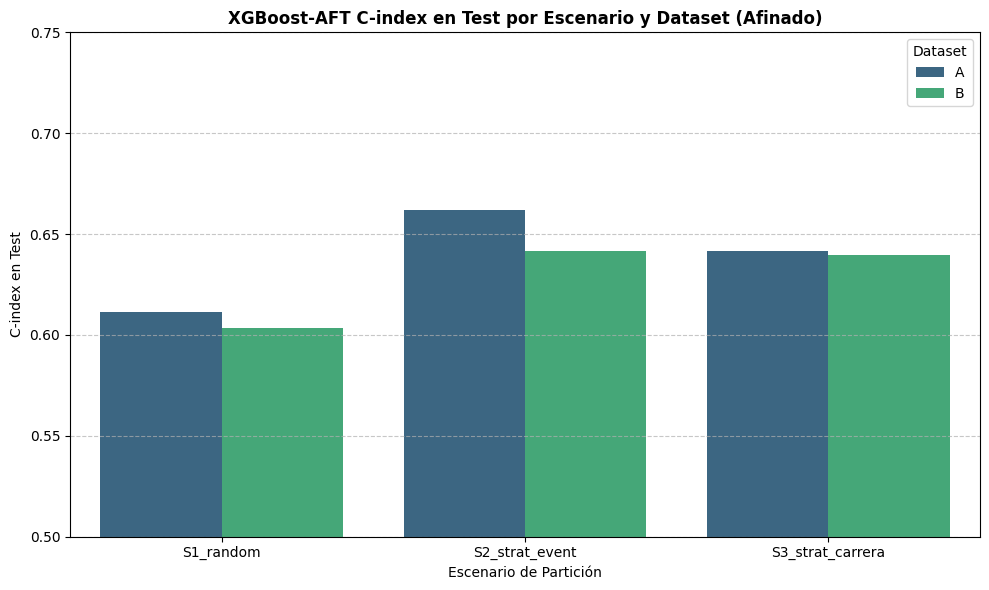

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=results_xgb_tuned, x='split', y='test_cindex', hue='dataset', palette='viridis')
plt.title('XGBoost-AFT C-index en Test por Escenario y Dataset (Afinado)', fontweight='bold')
plt.xlabel('Escenario de Partición')
plt.ylabel('C-index en Test')
plt.ylim(0.5, 0.75) # Ajustar límites para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [68]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from scipy.stats import norm, logistic, gumbel_r

from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc, brier_score, integrated_brier_score
from sksurv.nonparametric import kaplan_meier_estimator

SEED = 42

# === Decide cómo elegir el "ganador" ===
# Opción A (recomendado por tesis): SIEMPRE usar S2_strat_event como escenario principal
PRIMARY_SPLIT = "S2_strat_event"

# Opción B: escoger mejor por test_cindex (si quieres mostrarlo como "ganador empírico")
# best = results_xgb_tuned.sort_values("test_cindex", ascending=False).iloc[0]
# best_ds, best_split = best["dataset"], best["split"]

# Aquí fijamos por diseño:
best_split = PRIMARY_SPLIT

# dataset principal: el mejor en S2 (A o B)
tmp = results_xgb_tuned[results_xgb_tuned["split"] == best_split].sort_values("test_cindex", ascending=False).iloc[0]
best_ds = tmp["dataset"]

print("✅ Escenario principal:", best_split)
print("✅ Dataset principal:", best_ds)
display(tmp)


✅ Escenario principal: S2_strat_event
✅ Dataset principal: A


,1
dataset,A
model,XGB-AFT
split,S2_strat_event
cv_cindex_mean,0.647522
cv_cindex_std,0.04651
test_cindex,0.662051
best_iter_cv_median,788
best_iter_test,609
device,cuda


In [90]:
def load_xgb_artifacts(ds, split, root="artifacts_xgb/refined_best"):
    # soporta que hayas guardado "refined" o solo el tuned
    # intenta primero refined; si no existe, usa el booster del dict models_xgb_tuned
    refined_model = os.path.join(root, f"xgb_aft_refined_{ds}_{split}.json")
    refined_params = os.path.join(root, f"refined_params_{ds}_{split}.json")

    if os.path.exists(refined_model) and os.path.exists(refined_params):
        booster = xgb.Booster()
        booster.load_model(refined_model)
        with open(refined_params, "r", encoding="utf-8") as f:
            params = json.load(f)
        source = "refined_disk"
        return booster, params, source

    # fallback: usa lo que tienes en memoria por tuning
    params = models_xgb_tuned[(ds, split)]["best_params"]
    booster = models_xgb_tuned[(ds, split)]["booster"]
    source = "tuned_memory"
    return booster, params, source

booster_xgb, params_xgb, src = load_xgb_artifacts(best_ds, best_split)
print("✅ Booster cargado desde:", src)
print("aft_loss_distribution:", params_xgb.get("aft_loss_distribution", "normal"))
print("aft_loss_distribution_scale:", params_xgb.get("aft_loss_distribution_scale", 1.0))


✅ Booster cargado desde: refined_disk
aft_loss_distribution: normal
aft_loss_distribution_scale: 2.8551127078884506


In [91]:
def make_time_proxy(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).values

    # para eventos: midpoint; para censura: T_Lower
    t_mid_evt = (lo + up) / 2.0
    t = np.where(y_df["Event"].astype(int).values == 1, t_mid_evt, lo)

    # evita ceros (log)
    t = np.clip(t, 1e-6, None)

    e = y_df["Event"].astype(int).values.astype(bool)
    return t, e

def y_struct_from_proxy(y_df):
    t, e = make_time_proxy(y_df)
    return np.array(list(zip(e, t)), dtype=[("event", "?"), ("time", "<f8")])

def cindex(event_bool, time, risk):
    return concordance_index_censored(event_bool, time, risk)[0]

def aft_survival_matrix(mu_logtime, times, dist="normal", scale=1.0):
    """
    mu_logtime: predicción del booster (XGB-AFT suele devolver log(t) esperado / ubicación)
    times: array 1D en escala original
    devuelve S_hat(t) para cada sample y cada t  => shape (n_samples, n_times)
    """
    times = np.asarray(times, dtype=float)
    times = np.clip(times, 1e-6, None)

    z = (np.log(times)[None, :] - mu_logtime[:, None]) / float(scale)

    if dist == "normal":
        F = norm.cdf(z)
    elif dist == "logistic":
        F = logistic.cdf(z)
    elif dist == "extreme":
        F = gumbel_r.cdf(z)
    else:
        # fallback
        F = norm.cdf(z)

    S = 1.0 - F
    return S


In [92]:
# Seleccionar X,y,splits correctos según dataset
if best_ds == "A":
    X, y, splits = X_A, y_A, splits_A
else:
    X, y, splits = X_B, y_B, splits_B

tr, te = splits[best_split]
Xtr, Xte = X.iloc[tr].reset_index(drop=True), X.iloc[te].reset_index(drop=True)
ytr, yte = y.iloc[tr].reset_index(drop=True), y.iloc[te].reset_index(drop=True)

print("Shapes:", Xtr.shape, Xte.shape, ytr.shape, yte.shape)

ytr_s = y_struct_from_proxy(ytr)
yte_s = y_struct_from_proxy(yte)


Shapes: (532, 103) (133, 103) (532, 3) (133, 3)


In [93]:
dte = xgb.DMatrix(Xte)
mu_te = booster_xgb.predict(dte)              # pred log-time (mu)
risk_te = -mu_te                             # mayor risk => evento antes

t_te, e_te = make_time_proxy(yte)
ci = cindex(e_te, t_te, risk_te)
print(f"✅ XGB-AFT c-index (proxy) en TEST [{best_ds}|{best_split}]: {ci:.4f}")


✅ XGB-AFT c-index (proxy) en TEST [A|S2_strat_event]: 0.6788


CELDA V5 — Gráfica 1: Kaplan-Meier por grupos de riesgo (terciles)

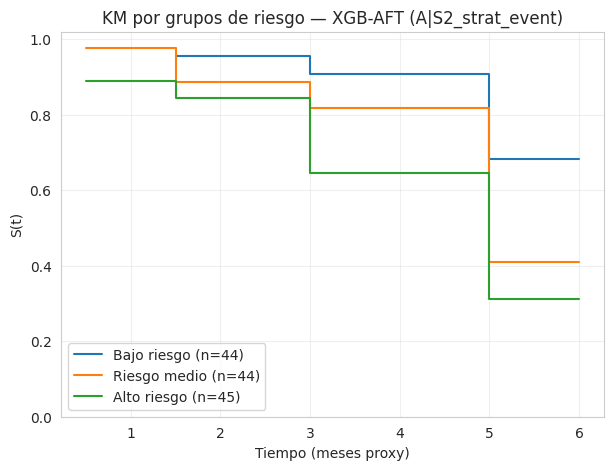

In [94]:
def km_step_value(times_km, surv_km, t0):
    # devuelve S(t0) como el último valor disponible <= t0
    idx = np.searchsorted(times_km, t0, side="right") - 1
    if idx < 0:
        return 1.0
    return float(surv_km[idx])

def plot_km_by_risk_groups(time, event, risk, title, out=None):
    q1, q2 = np.quantile(risk, [0.33, 0.66])
    grp = np.where(risk <= q1, "Bajo riesgo", np.where(risk <= q2, "Riesgo medio", "Alto riesgo"))

    plt.figure(figsize=(7,5))
    for g in ["Bajo riesgo","Riesgo medio","Alto riesgo"]:
        m = (grp == g)
        t_km, s_km = kaplan_meier_estimator(event[m], time[m])
        plt.step(t_km, s_km, where="post", label=f"{g} (n={m.sum()})")

    plt.xlabel("Tiempo (meses proxy)")
    plt.ylabel("S(t)")
    plt.title(title)
    plt.ylim(0,1.02)
    plt.grid(True, alpha=0.3)
    plt.legend()
    if out:
        plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()

plot_dir = "fig_eval_xgb"
os.makedirs(plot_dir, exist_ok=True)

plot_km_by_risk_groups(
    time=t_te, event=e_te, risk=risk_te,
    title=f"KM por grupos de riesgo — XGB-AFT ({best_ds}|{best_split})",
    out=os.path.join(plot_dir, f"KM_riskgroups_XGB_{best_ds}_{best_split}.png")
)


CELDA V6 — Gráfica 2: AUC dependiente del tiempo (cumulative_dynamic_auc)

In [95]:
# grid de tiempos: usa rango observado (proxy)
t_min = max(0.5, np.min(t_te))
t_max = np.max(t_te)
times_auc = np.linspace(t_min, t_max, 8)

auc, mean_auc = cumulative_dynamic_auc(ytr_s, yte_s, risk_te, times_auc)

plt.figure(figsize=(7,5))
plt.plot(times_auc, auc, marker="o")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("AUC(t)")
plt.title(f"AUC dependiente del tiempo — XGB-AFT ({best_ds}|{best_split}) | meanAUC={mean_auc:.3f}")
plt.ylim(0,1.02)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(plot_dir, f"AUC_time_XGB_{best_ds}_{best_split}.png"), dpi=160, bbox_inches="tight")
plt.show()

print("meanAUC:", float(mean_auc))


ValueError: all times must be within follow-up time of test data: [0.5; 6.0[

CELDA V7 — Gráfica 3: Brier Score(t) + IBS (calibración global)

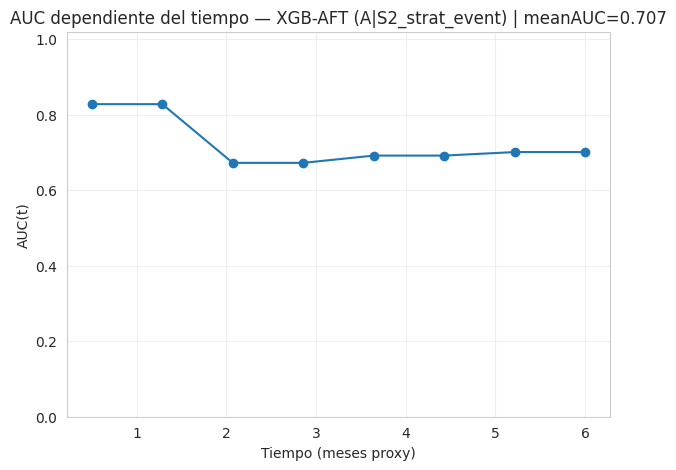

times_auc: [0.500001 1.285715 2.071429 2.857143 3.642857 4.428571 5.214285 5.999999]
meanAUC: 0.7068251930709265


In [97]:
# --- FIX AUC(t) times dentro del rango del TEST ---
t_test = yte_s["time"].astype(float)

t_min = float(np.min(t_test))
t_max = float(np.max(t_test))

eps = 1e-6
left = t_min + eps
right = t_max - eps

# si por alguna razón quedan iguales, fuerza un rango mínimo
if right <= left:
    left = t_min + 1e-3
    right = t_max - 1e-3

times_auc = np.linspace(left, right, 8)

auc, mean_auc = cumulative_dynamic_auc(ytr_s, yte_s, risk_te, times_auc)

plt.figure(figsize=(7,5))
plt.plot(times_auc, auc, marker="o")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("AUC(t)")
plt.title(f"AUC dependiente del tiempo — XGB-AFT ({best_ds}|{best_split}) | meanAUC={mean_auc:.3f}")
plt.ylim(0,1.02)
plt.grid(True, alpha=0.3)
plt.show()

print("times_auc:", times_auc)
print("meanAUC:", float(mean_auc))


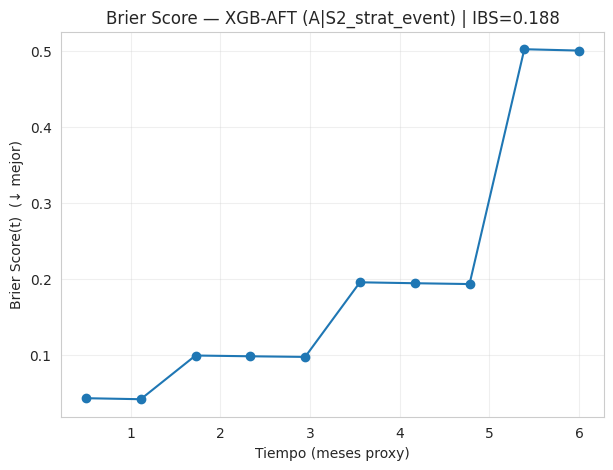

times_bs: [0.500001   1.11111189 1.72222278 2.33333367 2.94444456 3.55555544
 4.16666633 4.77777722 5.38888811 5.999999  ]
IBS: 0.18824009353808496


In [98]:
# --- Distribución AFT del booster ---
dist  = params_xgb.get("aft_loss_distribution", "normal")
scale = float(params_xgb.get("aft_loss_distribution_scale", 1.0))

# --- Rango válido de tiempos (estricto) basado en el TEST ---
t_test = yte_s["time"].astype(float)
t_min_test = float(np.min(t_test))
t_max_test = float(np.max(t_test))

eps = 1e-6
left  = t_min_test + eps
right = t_max_test - eps

# Fallback si el rango queda degenerado (no debería, pero por seguridad)
if right <= left:
    left  = t_min_test + 1e-3
    right = t_max_test - 1e-3

# tiempos para Brier: estrictamente dentro del rango del test
times_bs = np.linspace(left, right, 10)
times_bs = np.unique(times_bs)  # por si quedara algún duplicado numérico

# --- Predicción AFT (mu) en test y S(t|x) ---
mu_te = booster_xgb.predict(xgb.DMatrix(Xte))
S_te  = aft_survival_matrix(mu_te, times_bs, dist=dist, scale=scale)

# --- Brier / IBS ---
bs_t, bs = brier_score(ytr_s, yte_s, S_te, times_bs)
ibs = integrated_brier_score(ytr_s, yte_s, S_te, times_bs)

plt.figure(figsize=(7,5))
plt.plot(times_bs, bs, marker="o")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Brier Score(t)  (↓ mejor)")
plt.title(f"Brier Score — XGB-AFT ({best_ds}|{best_split}) | IBS={float(ibs):.3f}")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(plot_dir, f"Brier_XGB_{best_ds}_{best_split}.png"), dpi=160, bbox_inches="tight")
plt.show()

print("times_bs:", times_bs)
print("IBS:", float(ibs))


CELDA V8 — Gráfica 4: Calibration plot en un horizonte t0 (ej. 6 meses)

t0 usado: 6.0000 | bins pedidos=5 | bins efectivos=5 | bins graficados=4
n por bin graficado: [53, 27, 26, 27]


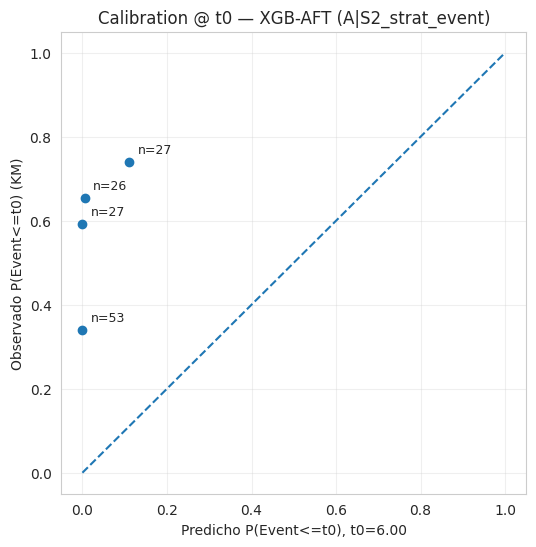

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

def km_step_value(t_km, s_km, t0):
    # valor escalonado S(t0) (KM es right-continuous en sksurv)
    # buscamos último t_km <= t0
    idx = np.searchsorted(t_km, t0, side="right") - 1
    if idx < 0:
        return 1.0
    return float(s_km[idx])

def calibration_at_t0_debug(yte_s, S_te, times_bs, t0, n_bins=5, min_bin=10, title="", out=None):
    # --- asegurar t0 dentro del follow-up del TEST ---
    t_test = yte_s["time"].astype(float)
    e_test = yte_s["event"].astype(bool)

    eps = 1e-6
    t0 = float(np.clip(t0, float(t_test.min()) + eps, float(t_test.max()) - eps))

    # --- predicción: P(event <= t0) = 1 - S(t0) ---
    j = int(np.argmin(np.abs(times_bs - t0)))
    s_hat = S_te[:, j]
    p_event = 1.0 - s_hat

    # --- bins por cuantiles (robusto a empates) ---
    qs = np.quantile(p_event, np.linspace(0, 1, n_bins + 1))
    qs[0], qs[-1] = -1e-9, 1 + 1e-9
    # si hay bordes repetidos, reduce bins efectivos
    qs = np.unique(qs)
    if len(qs) <= 2:
        print("⚠️ p_event muy concentrado: no hay cortes suficientes para bins.")
        return

    bin_id = np.digitize(p_event, qs) - 1
    n_eff_bins = int(bin_id.max() + 1)

    pred, obs, ns = [], [], []
    for b in range(n_eff_bins):
        m = (bin_id == b)
        nb = int(m.sum())
        if nb < min_bin:
            continue

        pred_b = float(np.mean(p_event[m]))

        t_km, s_km = kaplan_meier_estimator(e_test[m], t_test[m])
        s0 = km_step_value(t_km, s_km, t0)
        obs_b = float(1.0 - s0)

        pred.append(pred_b); obs.append(obs_b); ns.append(nb)

    print(f"t0 usado: {t0:.4f} | bins pedidos={n_bins} | bins efectivos={n_eff_bins} | bins graficados={len(pred)}")
    print("n por bin graficado:", ns)

    # --- plot ---
    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1], linestyle="--")
    plt.scatter(pred, obs)

    for x, y, n in zip(pred, obs, ns):
        plt.annotate(f"n={n}", (x, y), textcoords="offset points", xytext=(6,6), fontsize=9)

    plt.xlabel(f"Predicho P(Event<=t0), t0={t0:.2f}")
    plt.ylabel("Observado P(Event<=t0) (KM)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    if out:
        plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()

# ejemplo de uso: t0=6 pero ajustado a rango test automáticamente
calibration_at_t0_debug(
    yte_s, S_te, times_bs, t0=6.0, n_bins=5, min_bin=10,
    title=f"Calibration @ t0 — XGB-AFT ({best_ds}|{best_split})",
    out=os.path.join(plot_dir, f"Calibration_XGB_{best_ds}_{best_split}.png")
)


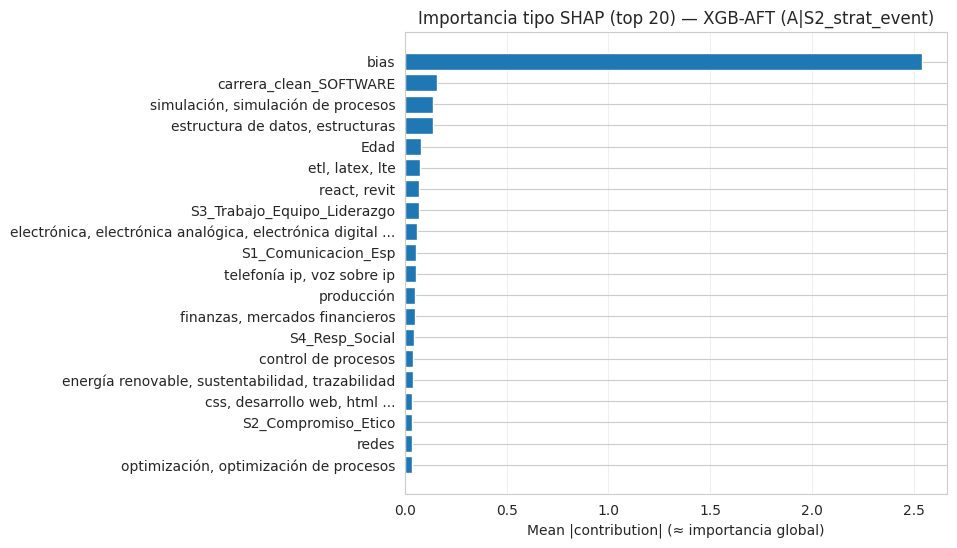

,feature,mean_abs_contrib
103,bias,2.538635
100,carrera_clean_SOFTWARE,0.157254
65,"simulación, simulación de procesos",0.138090
37,"estructura de datos, estructuras",0.136473
7,Edad,0.078878
38,"etl, latex, lte",0.074280
63,"react, revit",0.069850
2,S3_Trabajo_Equipo_Liderazgo,0.068512
35,"electrónica, electrónica analógica, electrónic...",0.059538
0,S1_Comunicacion_Esp,0.054520


In [100]:
# Contribuciones tipo SHAP (pred_contribs) de XGBoost
dte = xgb.DMatrix(Xte)
contrib = booster_xgb.predict(dte, pred_contribs=True)  # (n, p+1) incluye bias
feat_names = list(Xte.columns) + ["bias"]

mean_abs = np.mean(np.abs(contrib), axis=0)
imp = pd.DataFrame({"feature": feat_names, "mean_abs_contrib": mean_abs}).sort_values("mean_abs_contrib", ascending=False)

topk = 20
imp_top = imp.head(topk).iloc[::-1]

plt.figure(figsize=(7,6))
plt.barh(imp_top["feature"], imp_top["mean_abs_contrib"])
plt.xlabel("Mean |contribution| (≈ importancia global)")
plt.title(f"Importancia tipo SHAP (top {topk}) — XGB-AFT ({best_ds}|{best_split})")
plt.grid(True, axis="x", alpha=0.3)
plt.savefig(os.path.join(plot_dir, f"SHAPlike_top{topk}_XGB_{best_ds}_{best_split}.png"), dpi=160, bbox_inches="tight")
plt.show()

display(imp.head(30))


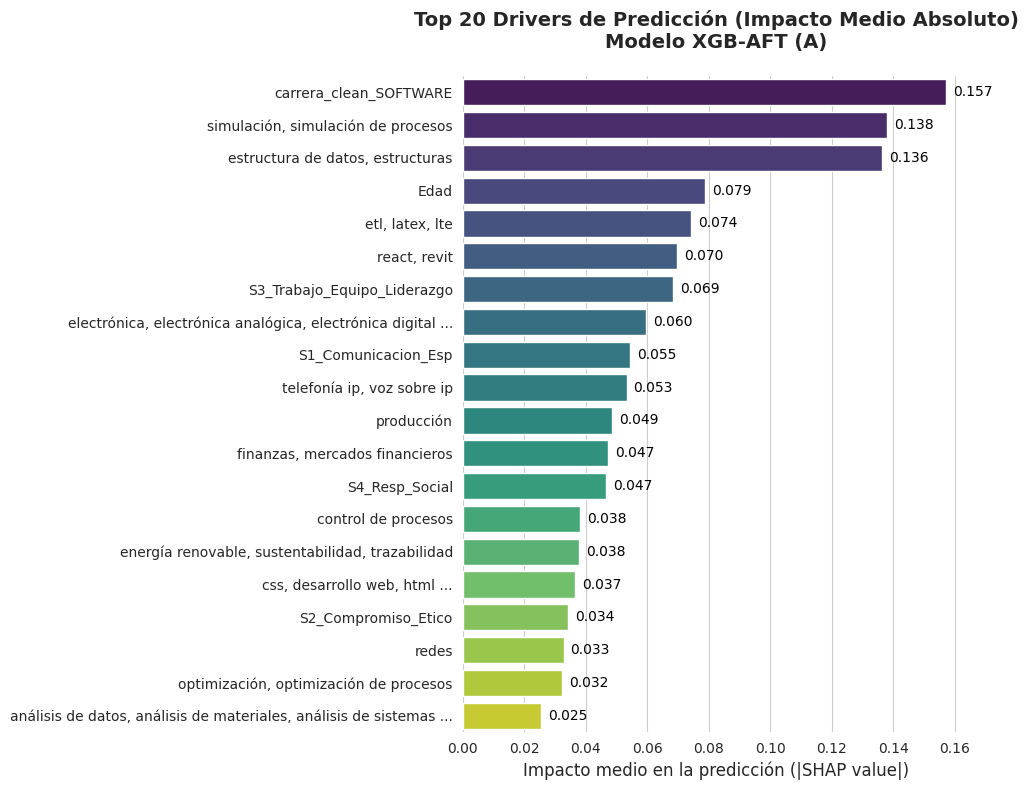

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
import os

# Suponiendo que ya tienes Xte, booster_xgb, best_ds, best_split y plot_dir definidos

# 1. Calcular contribuciones
dte = xgb.DMatrix(Xte)
contrib = booster_xgb.predict(dte, pred_contribs=True)

# 2. Mapear nombres (Excluyendo el Bias para el gráfico)
feat_names = list(Xte.columns) + ["bias"]
mean_abs = np.mean(np.abs(contrib), axis=0)
imp = pd.DataFrame({"feature": feat_names, "mean_abs_contrib": mean_abs})

# FILTRO IMPORTANTE: Quitamos el 'bias' porque distorsiona la escala de las variables reales
imp = imp[imp["feature"] != "bias"].sort_values("mean_abs_contrib", ascending=False)

topk = 20
imp_top = imp.head(topk)  # No invertimos todavía para que seaborn lo maneje mejor

# 3. Visualización Mejorada
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid") # Fondo limpio con rejilla suave

# Gráfico de barras con paleta de color semántica (mako o viridis)
# El color más oscuro indica mayor importancia
ax = sns.barplot(data=imp_top, x="mean_abs_contrib", y="feature",
                 palette="viridis", hue="feature", dodge=False, legend=False)

# Títulos y Etiquetas Profesionales
plt.title(f'Top {topk} Drivers de Predicción (Impacto Medio Absoluto)\nModelo XGB-AFT ({best_ds})',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Impacto medio en la predicción (|SHAP value|)", fontsize=12)
plt.ylabel("") # Quitamos label de Y porque los nombres ya explican

# 4. Añadir valores al final de las barras (Data Labels)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', padding=5, fontsize=10, color='black')

# Limpiar bordes innecesarios (Spines)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"SHAP_Global_top{topk}_Mejorado.png"), dpi=300)
plt.show()

,S1_Comunicacion_Esp,S2_Compromiso_Etico,S3_Trabajo_Equipo_Liderazgo,S4_Resp_Social,S5_Gestion_Proyectos,S6_Aprendizaje_Digital,S7_Ingles,Edad,Genero_bin,"administración de empresas, gestión de calidad, gestión de datos ...",...,carrera_clean_INGENIERÍA DE LA PRODUCCIÓN,carrera_clean_INGENIERÍA QUÍMICA,carrera_clean_MATEMÁTICA,carrera_clean_MATEMÁTICA APLICADA,carrera_clean_MECÁNICA,carrera_clean_PETRÓLEOS,carrera_clean_REDES Y TELECOMUNICACIONES,carrera_clean_SOFTWARE,carrera_clean_TECNOLOGÍAS DE LA INFORMACIÓN,carrera_clean_TELECOMUNICACIONES
45,4.0,5.0,4.0,5.0,4.0,5.0,4.0,23,1,0.001525,...,0,0,0,0,0,0,0,0,0,1
471,4.0,3.0,3.0,3.0,3.0,4.0,2.0,25,1,0.000866,...,0,0,0,0,1,0,0,0,0,0
430,4.0,5.0,3.0,4.0,3.0,3.0,3.0,26,0,0.002013,...,0,0,0,0,0,0,0,0,0,0
72,4.0,4.0,4.0,4.0,4.0,4.0,3.0,23,1,0.001165,...,0,0,0,0,0,0,0,0,0,0
80,5.0,5.0,5.0,5.0,5.0,5.0,5.0,26,0,0.002013,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,4.0,5.0,5.0,5.0,3.0,5.0,4.0,24,0,0.001165,...,0,0,0,0,0,0,0,1,0,0
558,4.0,5.0,4.0,4.0,5.0,5.0,5.0,23,1,0.001165,...,0,0,0,0,0,0,0,1,0,0
587,5.0,5.0,5.0,5.0,5.0,3.0,4.0,24,1,0.002625,...,0,0,0,0,0,0,0,0,0,0
579,4.0,4.0,5.0,4.0,5.0,5.0,4.0,23,1,0.000766,...,0,0,0,0,0,0,0,0,0,0


**

# ¿Puede la carrera ser predictora?

Basado en la evidencia acumulada en el corpus documental proporcionado, la respuesta es afirmativa: la carrera (denominada en la literatura como field of study, major, specialization o degree subject) es un predictor estadísticamente significativo y robusto tanto de la probabilidad de empleo como del tiempo de inserción laboral.

A continuación, se detalla cómo la literatura modela y justifica la carrera como predictor:

### 1\. Predictor de la Velocidad de Inserción (Modelos de Duración y Supervivencia)

En los estudios que utilizan análisis de supervivencia (modelos Cox o AFT), la carrera actúa como una variable covariable que modifica la tasa de riesgo (hazard rate) de encontrar empleo.

-   Aceleración del Tiempo: En el contexto español, Cordón-Lagares et al. (2022) encontraron que los titulados en Ciencias de la Salud y Ingeniería tienen tiempos de transición al primer empleo significativamente más cortos en comparación con los de Artes y Humanidades. Específicamente, en su modelo Log-Normal, el coeficiente para "Salud" ($-0.762$) y "Ingeniería" ($-0.253$) indica que estas carreras "aceleran" el evento de empleo, reduciendo el tiempo de desempleo 1.

-   Diferencias Significativas: Salas-Velasco (2024), utilizando un modelo logit ordenado para datos agrupados (grouped duration data), corroboró que los graduados en Ingeniería y Arquitectura experimentan una transición más suave y rápida hacia el mercado laboral en comparación con los graduados en Ciencias Duras (Hard Sciences), quienes mostraron tiempos de espera más largos 2.

-   Violación de Riesgos Proporcionales: Lalley (2025) señala que la variable "tema del título" (degree subject) a menudo viola el supuesto de riesgos proporcionales en los modelos de Cox, lo que implica que el efecto predictivo de la carrera no es constante; por ejemplo, ciertas carreras pueden tener una ventaja inicial que se disipa con el tiempo. Su estudio en el Reino Unido mostró que los graduados en STEM y Negocios tienen tasas de riesgo de empleo más altas que sus pares de Artes 3.

### 2\. Predictor de Probabilidad de Empleo (Modelos de Clasificación y Regresión)

En modelos probabilísticos (Logit, Probit y Multinivel), la carrera define la probabilidad base de estar empleado frente a estar desempleado o inactivo.

-   Variabilidad entre Grupos (Efectos Aleatorios): Gabreyohannes (2024) demostró, mediante un modelo de regresión logística multinivel, que existe una variación significativa en los log-odds de empleo atribuible al campo de especialización. Los graduados en Gestión, Contabilidad y Ciencias de la Computación mostraron intervalos de confianza significativamente superiores al promedio, mientras que carreras como Geografía, Historia y Agricultura se situaron por debajo 4.

-   Transiciones Laborales: Moreno-Gómez et al. (2025) encontraron en su modelo logit multinomial que estudiar carreras de Negocios (Business Studies) tiene un efecto marginal positivo y significativo en la transición hacia el empleo (coeficiente de 0.495 a 1.397), mientras que estudiar Ciencias Sociales mostró un efecto negativo ($-0.505$) en la probabilidad de inserción al finalizar los estudios 5.

-   Probabilidad Condicional: De Iaco et al. (2018) reportaron que tener un título en Ingeniería aumentaba la probabilidad de obtener un empleo en un 130% (Odds Ratio = 2.30) en comparación con un título humanístico, siendo el predictor más fuerte en su modelo multinivel para graduados italianos 6.

### 3\. Importancia de la Característica en Machine Learning

En algoritmos de aprendizaje supervisado, la carrera es seleccionada consistentemente como una característica crítica para la precisión del modelo.

-   Ranking de Características: Jayachandran y Joshi (2024), al aplicar técnicas de selección de características (Feature Selection) para predecir la empleabilidad en ingeniería, identificaron que la especialización (rama de la ingeniería) es una característica de alto rango (Rank 3) que influye directamente en la predicción, junto con el rendimiento académico en semestres específicos 7.

-   Contexto de Pasantía: Saidani et al. (2022) argumentan que, aunque la carrera es importante, el contexto de la pasantía realizado dentro de esa especialidad tiene un peso predictivo superior en modelos de Gradient Boosting (XGBoost/LightGBM) para determinar el estado final de empleo 8.

### 4\. Matices: Interacción con Género y Calidad

La literatura advierte que la carrera no predice por sí sola de manera aislada, sino que interactúa con otras variables estructurales.

-   Brecha de Género en STEM: Valdés y Solga (2024) destacan que, incluso dentro de las carreras STEM (que teóricamente garantizan alta empleabilidad), las mujeres tienen una menor probabilidad de acceder a ocupaciones STEM y salarios altos en comparación con los hombres, lo que sugiere que el poder predictivo de la carrera está moderado por el género 9.

### Referencias

1 E. Cordón-Lagares, F. García-Ordaz, and J. J. García-del-Hoyo, "The transition from higher education to first employment in Spain," European Journal of Education, 2022.2 M. Salas-Velasco, "Transitioning from the University to the Workplace: A Duration Model with Grouped Data," Stats, vol. 7, pp. 719--731, 2024.3 C. Lalley, "Time to Graduate Level Employment for New Graduates in the United Kingdom," Kyklos, 2025.4 E. Gabreyohannes, "Multilevel Logistic Regression Analysis of Correlates of Graduate Employment by Fields of Specialization," Journal of Statistics Applications & Probability, vol. 13, no. 4, pp. 1263--1277, 2024.5 J. Moreno-Gómez et al., "Student Employment Transitions: Average Marginal Effect," TEM Journal, vol. 14, pp. 429--437, Feb. 2025.6 S. De Iaco, S. Maggio, and D. Posa, "A Multilevel Multinomial Model for the Dynamics of Graduates Employment in Italy," Social Indicators Research, 2018.7 S. Jayachandran and B. Joshi, "Customized support vector machine for predicting the employability of students pursuing engineering," International Journal of Information Technology, 2024.8 O. Saidani, L. J. Menzli, A. Ksibi, N. Alturki, and A. S. Alluhaidan, "Predicting Student Employability Through the Internship Context Using Gradient Boosting Models," IEEE Access, vol. 10, pp. 46472--46489, 2022.9 M. T. Valdés and H. Solga, "The STEM leaky pipeline at labor market entry in Spain: The role of job competition and social origin," Social Science Research, vol. 124, p. 103092, 2024.

**

In [84]:
import os
from google.colab import files

# 1. Definimos el nombre del archivo comprimido
zip_name = "archivos_colab.zip"

# 2. Ejecutamos el comando zip en la terminal
# '*' selecciona todo, '-r' es recursivo, '-x' excluye patrones
!zip -r {zip_name} . -x "sample_data/*" "{zip_name}"

# 3. Descargamos el archivo a tu computadora local
files.download(zip_name)

  adding: .config/ (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2025.12.09/ (stored 0%)
  adding: .config/logs/2025.12.09/14.41.43.412452.log (deflated 56%)
  adding: .config/logs/2025.12.09/14.40.47.605300.log (deflated 92%)
  adding: .config/logs/2025.12.09/14.41.42.675750.log (deflated 57%)
  adding: .config/logs/2025.12.09/14.41.27.893750.log (deflated 86%)
  adding: .config/logs/2025.12.09/14.41.18.717681.log (deflated 58%)
  adding: .config/logs/2025.12.09/14.41.33.792924.log (deflated 58%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/default_configs.db (deflated 98%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/.last_update_check

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

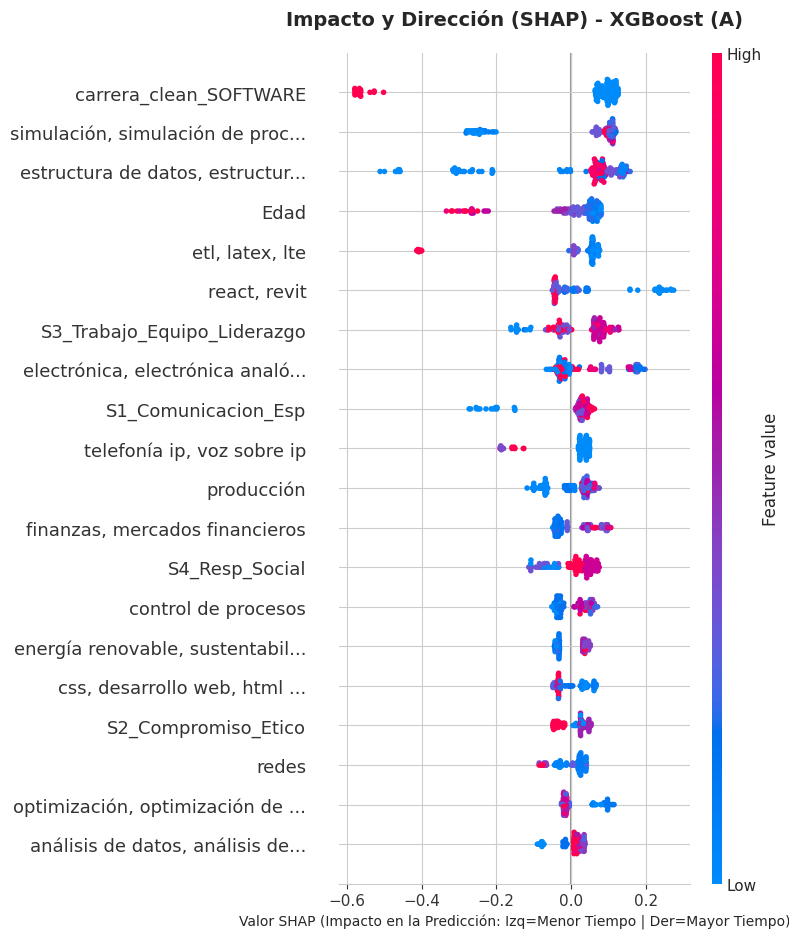

✅ Gráfico de puntos generado con tus variables reales.


In [113]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import os

# ==============================================================================
# 1. Tu Lógica Base (Calculamos contribuciones con XGBoost Nativo)
# ==============================================================================
# Usamos tu matriz y modelo existentes
dte = xgb.DMatrix(Xte)
contribs = booster_xgb.predict(dte, pred_contribs=True)

# ¡PASO CRUCIAL!: 'pred_contribs' devuelve (n_samples, n_features + 1).
# La última columna es el 'Bias' (el intercepto).
# Para el gráfico de puntos, necesitamos solo las features, así que lo quitamos:
shap_values = contribs[:, :-1]

# ==============================================================================
# 2. Manejo de Nombres Largos (Solo visualización)
# ==============================================================================
# Cortamos los nombres a 30 caracteres para que no tapen el gráfico
nombres_cortos = [c[:30] + "..." if len(c) > 30 else c for c in Xte.columns]

# ==============================================================================
# 3. Generar el Gráfico Beeswarm (Puntos) usando tus datos
# ==============================================================================
plt.figure(figsize=(10, 8))

# Usamos la librería SHAP directamente con los valores que calculaste
shap.summary_plot(
    shap_values,            # Tus contribuciones calculadas (sin bias)
    Xte,                    # Tus datos reales (para saber si el valor es alto/bajo - rojo/azul)
    feature_names=nombres_cortos, # Tus nombres de columnas recortados
    max_display=20,         # Top 20 variables
    plot_type="dot",        # <--- ESTO ES LO QUE CREA EL GRÁFICO DE PUNTOS
    show=False              # Para poder editar el título
)

# Ajustes Finales
plt.title(f"Impacto y Dirección (SHAP) - XGBoost ({best_ds})", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Valor SHAP (Impacto en la Predicción: Izq=Menor Tiempo | Der=Mayor Tiempo)", fontsize=10)

# Guardar
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"SHAP_Beeswarm_top20_{best_ds}.png"), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico de puntos generado con tus variables reales.")

In [114]:
import os
import pandas as pd

ART_DIR = "/content/artifacts_xgb"
results_path = os.path.join(ART_DIR, "results_xgb_aft_random_cv.csv")

results = pd.read_csv(results_path)
best = results.sort_values("test_cindex", ascending=False).iloc[0]

best_ds = best["dataset"]
best_split = best["split"]
best_test = float(best["test_cindex"])

best_refined_path = os.path.join(
    ART_DIR, "refined_best", f"xgb_aft_refined_best_{best_ds}_{best_split}.json"
)

print("✅ Mejor (por test_cindex):", best_ds, best_split, "| test_cindex =", best_test)
print("📌 Ruta modelo refinado:", best_refined_path)
print("¿Existe?:", os.path.exists(best_refined_path))


✅ Mejor (por test_cindex): A S2_strat_event | test_cindex = 0.662051282051282
📌 Ruta modelo refinado: /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event.json
¿Existe?: True


In [115]:
import shutil
from google.colab import files

src_dir = "/content/artifacts_xgb"
zip_base = "/content/artifacts_xgb_full"  # sin .zip aquí

zip_path = shutil.make_archive(zip_base, "zip", src_dir)
print("✅ ZIP creado:", zip_path)

files.download(zip_path)


✅ ZIP creado: /content/artifacts_xgb_full.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#AUI


In [116]:
import os, json
import numpy as np
import pandas as pd
import xgboost as xgb

ART_DIR = "/content/artifacts_xgb"
RES_PATH = os.path.join(ART_DIR, "results_xgb_aft_random_cv.csv")

results = pd.read_csv(RES_PATH)
best = results.sort_values("test_cindex", ascending=False).iloc[0]

best_ds = best["dataset"]
best_split = best["split"]
best_test = float(best["test_cindex"])

BEST_DIR = os.path.join(ART_DIR, "refined_best")
model_path = os.path.join(BEST_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}.json")
meta_path  = os.path.join(BEST_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}_meta.json")

print("✅ Mejor modelo por test_cindex:", best_ds, best_split, "| test_cindex =", best_test)
print("📌 model:", model_path, "| exists:", os.path.exists(model_path))
print("📌 meta :", meta_path,  "| exists:", os.path.exists(meta_path))

booster = xgb.Booster()
booster.load_model(model_path)

meta = {}
if os.path.exists(meta_path):
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

feat_names = meta.get("feature_names", None)  # ideal para ordenar columnas
params_xgb = meta.get("best_params", meta.get("params", {}))

print("feature_names en meta:", (feat_names is not None), "| n_features:", (len(feat_names) if feat_names else "NA"))
print("dist/scale:", params_xgb.get("aft_loss_distribution"), params_xgb.get("aft_loss_distribution_scale"))


✅ Mejor modelo por test_cindex: A S2_strat_event | test_cindex = 0.662051282051282
📌 model: /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event.json | exists: True
📌 meta : /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event_meta.json | exists: True
feature_names en meta: False | n_features: NA
dist/scale: None None


In [117]:
# Seleccionar dataset A/B según best_ds
if best_ds == "A":
    X_use, y_use, splits_use = X_A, y_A, splits_A
else:
    X_use, y_use, splits_use = X_B, y_B, splits_B

tr, te = splits_use[best_split]
Xte = X_use.iloc[te].reset_index(drop=True)
yte = y_use.iloc[te].reset_index(drop=True)

# Ordenar columnas exactamente como se entrenó (si meta trae feature_names)
if feat_names is not None:
    missing = sorted(set(feat_names) - set(Xte.columns))
    extra   = sorted(set(Xte.columns) - set(feat_names))
    if missing:
        raise ValueError(f"❌ Faltan features en Xte vs meta: {missing[:10]} ...")
    # reordenar y eliminar extras
    Xte = Xte[feat_names].copy()

print("✅ Xte shape:", Xte.shape, "| yte shape:", yte.shape)


✅ Xte shape: (133, 103) | yte shape: (133, 3)


In [118]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

def make_t_mid(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).replace(np.inf, np.nan).values
    cap = np.nanmax(up) if np.isfinite(np.nanmax(up)) else np.nanmax(lo)
    up_cap = np.where(np.isfinite(y_df["T_Upper"].astype(float).values),
                      y_df["T_Upper"].astype(float).values, cap)
    return (lo + up_cap) / 2.0

def aft_survival_matrix(mu, times, dist="normal", scale=1.0):
    """
    XGBoost AFT: predice mu en escala log(T).
    Para t>0: z = (log(t) - mu) / scale
    S(t) = 1 - CDF(z)
    dist ∈ {"normal","logistic","extreme"} (extreme = gumbel_l / mínimo)
    """
    mu = np.asarray(mu).reshape(-1, 1)
    times = np.asarray(times).reshape(1, -1)
    times = np.clip(times, 1e-6, None)  # evitar log(0)
    z = (np.log(times) - mu) / float(scale)

    dist = (dist or "normal").lower()
    if dist == "normal":
        # Φ(z) usando erf
        cdf = 0.5 * (1.0 + np.erf(z / np.sqrt(2.0)))
        return 1.0 - cdf
    elif dist == "logistic":
        cdf = 1.0 / (1.0 + np.exp(-z))
        return 1.0 - cdf
    elif dist == "extreme":
        # mínimo extreme value (gumbel_l): CDF = 1 - exp(-exp(z)) => S = exp(-exp(z))
        return np.exp(-np.exp(z))
    else:
        raise ValueError(f"Distribución AFT no soportada: {dist}")


In [119]:
import os

PLOT_DIR = os.path.join(ART_DIR, "plots_mvp")
os.makedirs(PLOT_DIR, exist_ok=True)

# Observado (KM) en test usando T_mid proxy
t_te = make_t_mid(yte)
e_te = yte["Event"].astype(int).values.astype(bool)

t_km, s_km = kaplan_meier_estimator(e_te, t_te)

# Predicción AFT (mu) y S(t)
dte = xgb.DMatrix(Xte, feature_names=list(Xte.columns))
mu_te = booster.predict(dte)

dist  = params_xgb.get("aft_loss_distribution", "normal")
scale = float(params_xgb.get("aft_loss_distribution_scale", 1.0))

t_min = max(float(np.min(t_te)), 1e-3)
t_max = float(np.max(t_te))
times = np.linspace(t_min, np.nextafter(t_max, t_min), 80)  # < t_max (evita bordes)

S_te = aft_survival_matrix(mu_te, times, dist=dist, scale=scale)
S_mean = S_te.mean(axis=0)

# (G1) S(t)
plt.figure(figsize=(7,5))
plt.step(t_km, s_km, where="post", label="KM observada (test)")
plt.plot(times, S_mean, label="S(t) predicha (promedio)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Supervivencia S(t) = P(no empleo hasta t)")
plt.title(f"XGB-AFT — KM observada vs predicha | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()
out1 = os.path.join(PLOT_DIR, f"KM_vs_Pred_XGB_{best_ds}_{best_split}.png")
plt.savefig(out1, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out1)



AttributeError: module 'numpy' has no attribute 'erf'

ValueError: x and y must have same first dimension, but have shapes (80,) and (40,)

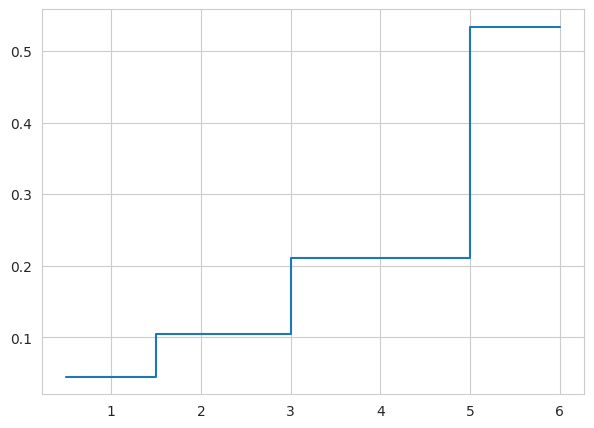

In [120]:
# (G2) 1 - S(t)
plt.figure(figsize=(7,5))
plt.step(t_km, 1.0 - s_km, where="post", label="Empleabilidad acumulada observada (KM)")
plt.plot(times, 1.0 - S_mean, label="Empleabilidad acumulada predicha (promedio)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("P(empleo antes de t)")
plt.title(f"XGB-AFT — Empleabilidad acumulada obs vs pred | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()
out2 = os.path.join(PLOT_DIR, f"Employability_Cum_XGB_{best_ds}_{best_split}.png")
plt.savefig(out2, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out2)


---
---
---
---

In [101]:
import os, json, ast
import numpy as np
import pandas as pd

ART_DIR = "mvp_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# ---------- 1) Guardar tablas (si existen) ----------
if "results_rsf" in globals():
    results_rsf.to_csv(os.path.join(ART_DIR, "results_rsf.csv"), index=False)
    print("✅ Guardado:", os.path.join(ART_DIR, "results_rsf.csv"))

if "results_xgb_tuned" in globals():
    results_xgb_tuned.to_csv(os.path.join(ART_DIR, "results_xgb_aft.csv"), index=False)
    print("✅ Guardado:", os.path.join(ART_DIR, "results_xgb_aft.csv"))

# ---------- 2) Guardar boosters XGB (si existen) ----------
if "models_xgb_tuned" in globals():
    for (ds, split), pack in models_xgb_tuned.items():
        booster = pack["booster"]
        best_params = pack.get("best_params", {})
        path_model = os.path.join(ART_DIR, f"xgb_aft_{ds}_{split}.json")
        path_meta  = os.path.join(ART_DIR, f"xgb_aft_{ds}_{split}_params.json")
        booster.save_model(path_model)
        with open(path_meta, "w", encoding="utf-8") as f:
            json.dump(best_params, f, ensure_ascii=False, indent=2)
    print("✅ Guardados boosters XGB-AFT + params JSON en", ART_DIR)

# ---------- 3) Refit y guardar el MEJOR RSF (si existe tabla RSF) ----------
# Nota: como tu flujo RSF no guardaba el objeto modelo, lo "refiteamos" SOLO para el mejor escenario (rápido)
if "results_rsf" in globals() and "X_A" in globals() and "splits_A" in globals():

    from sksurv.ensemble import RandomSurvivalForest
    import joblib

    # helpers (los mismos que vienes usando)
    def make_t_mid(y_df):
        lo = y_df["T_Lower"].astype(float).values
        up = y_df["T_Upper"].astype(float).replace(np.inf, np.nan).values
        cap = np.nanmax(up) if np.isfinite(np.nanmax(up)) else np.nanmax(lo)
        up_cap = np.where(np.isfinite(y_df["T_Upper"].astype(float).values),
                          y_df["T_Upper"].astype(float).values, cap)
        return (lo + up_cap) / 2.0

    def rsf_structured_y(y_df):
        t_mid = make_t_mid(y_df)
        e = y_df["Event"].astype(int).values.astype(bool)
        return np.array(list(zip(e, t_mid)), dtype=[("event", "?"), ("time", "<f8")])

    # escoger mejor fila global por cindex_test
    best_row = results_rsf.sort_values("cindex_test", ascending=False).iloc[0].to_dict()
    best_ds = best_row["dataset"]
    best_split = best_row["scenario"]  # en tu tabla RSF, la columna es "scenario"

    # elegir matrices correctas
    if best_ds == "A":
        X_use, y_use, splits_use = X_A, y_A, splits_A
    else:
        X_use, y_use, splits_use = X_B, y_B, splits_B

    # parse best_params (puede venir como string)
    bp = best_row["best_params"]
    if isinstance(bp, str):
        bp = ast.literal_eval(bp)

    tr, te = splits_use[best_split]
    Xtr = X_use.iloc[tr].reset_index(drop=True)
    ytr = y_use.iloc[tr].reset_index(drop=True)
    ytr_s = rsf_structured_y(ytr)

    rsf_best = RandomSurvivalForest(
        random_state=42, n_jobs=-1,
        **bp
    )
    rsf_best.fit(Xtr, ytr_s)

    joblib.dump(rsf_best, os.path.join(ART_DIR, f"rsf_best_{best_ds}_{best_split}.joblib"))
    with open(os.path.join(ART_DIR, f"rsf_best_{best_ds}_{best_split}_meta.json"), "w", encoding="utf-8") as f:
        json.dump(best_row, f, ensure_ascii=False, indent=2)

    print(f"✅ RSF BEST refit+guardado: rsf_best_{best_ds}_{best_split}.joblib")
    print("   Mejor RSF:", best_ds, best_split, "| cindex_test=", best_row["cindex_test"])


✅ Guardado: mvp_artifacts/results_xgb_aft.csv
✅ Guardados boosters XGB-AFT + params JSON en mvp_artifacts


In [105]:
import os, json
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# -------- CONFIG RUTAS --------
SRC_DIR = "mvp_artifacts"  # aquí están tus xgb_aft_*.json y results_xgb_aft.csv
OUT_DIR = "/content/artifacts_xgb/refined_best"
os.makedirs(OUT_DIR, exist_ok=True)

results_path = os.path.join(SRC_DIR, "results_xgb_aft.csv")
if not os.path.exists(results_path):
    raise FileNotFoundError(f"No encuentro {results_path}. Ajusta SRC_DIR o el nombre del archivo.")

# -------- 1) elegir el mejor escenario --------
res = pd.read_csv(results_path)
if "test_cindex" not in res.columns:
    raise ValueError("Tu results_xgb_aft.csv no tiene 'test_cindex'. Revisa columnas del CSV.")

best = res.sort_values("test_cindex", ascending=False).iloc[0].to_dict()
best_ds = best["dataset"]
best_split = best["split"]
print("✅ Mejor escenario (por test_cindex):", best_ds, best_split, "| test_cindex=", best["test_cindex"])

# -------- 2) elegir matrices correctas --------
if best_ds == "A":
    X, y, splits = X_A, y_A, splits_A
elif best_ds == "B":
    X, y, splits = X_B, y_B, splits_B
else:
    raise ValueError(f"dataset desconocido: {best_ds}")

if best_split not in splits:
    raise ValueError(f"No existe split {best_split} en splits_{best_ds}")

tr_idx, te_idx = splits[best_split]

# -------- 3) cargar best_params --------
params_path = os.path.join(SRC_DIR, f"xgb_aft_{best_ds}_{best_split}_params.json")
if not os.path.exists(params_path):
    raise FileNotFoundError(f"No encuentro params: {params_path}")

with open(params_path, "r", encoding="utf-8") as f:
    params_xgb = json.load(f)

# Forzar configuración GPU compatible con XGBoost moderno (evita gpu_hist)
# (si tu entorno no tiene GPU, puedes cambiar device="cpu")
params_xgb.update({
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "tree_method": "hist",
    "device": "cuda",
})

# -------- 4) helper: DMatrix interval-censored --------
def dmat_aft(X_df, y_df):
    d = xgb.DMatrix(X_df)
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).values
    d.set_float_info("label_lower_bound", lo)
    d.set_float_info("label_upper_bound", up)
    return d

# -------- 5) refinado: early stopping SOLO dentro del TRAIN externo --------
X_tr = X.iloc[tr_idx].reset_index(drop=True)
y_tr = y.iloc[tr_idx].reset_index(drop=True)

# val interno (estratificado por Event) para evitar tocar el test externo
event_tr = y_tr["Event"].astype(int).values
idx_all = np.arange(len(X_tr))
idx_fit, idx_val = train_test_split(
    idx_all, test_size=0.15, random_state=42, shuffle=True, stratify=event_tr
)

X_fit, y_fit = X_tr.iloc[idx_fit], y_tr.iloc[idx_fit]
X_val, y_val = X_tr.iloc[idx_val], y_tr.iloc[idx_val]

d_fit = dmat_aft(X_fit, y_fit)
d_val = dmat_aft(X_val, y_val)

# etapa 1: encontrar best_nrounds
booster_tmp = xgb.train(
    params=params_xgb,
    dtrain=d_fit,
    num_boost_round=5000,
    evals=[(d_val, "val")],
    early_stopping_rounds=50,
    verbose_eval=200
)
best_nrounds = int(booster_tmp.best_iteration + 1)
print("✅ best_nrounds (early stopping):", best_nrounds)

# etapa 2: entrenar “refinado final” usando TODO el train externo con nrounds fijo
d_train_full = dmat_aft(X_tr, y_tr)
booster_refined = xgb.train(
    params=params_xgb,
    dtrain=d_train_full,
    num_boost_round=best_nrounds,
    evals=[(d_val, "val")],
    verbose_eval=200
)

# -------- 6) guardar refinado --------
model_out = os.path.join(OUT_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}.json")
meta_out  = os.path.join(OUT_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}_meta.json")

booster_refined.save_model(model_out)

meta = {
    "best_row_from_results_csv": best,
    "dataset": best_ds,
    "split": best_split,
    "best_nrounds": best_nrounds,
    "params_used": params_xgb,
    "n_train_external": int(len(tr_idx)),
    "n_val_internal": int(len(idx_val)),
    "note": "Refinado entrenado SOLO con train externo; early stopping con val interno. Test externo NO usado para fit/early-stop."
}
with open(meta_out, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("\n✅ Guardado refinado en:")
print(" -", model_out)
print(" -", meta_out)


✅ Mejor escenario (por test_cindex): A S2_strat_event | test_cindex= 0.662051282051282
[0]	val-aft-nloglik:2.19653
[200]	val-aft-nloglik:1.68429
[400]	val-aft-nloglik:1.64475
[599]	val-aft-nloglik:1.64212
✅ best_nrounds (early stopping): 550
[0]	val-aft-nloglik:2.19657
[200]	val-aft-nloglik:1.67640
[400]	val-aft-nloglik:1.62583
[549]	val-aft-nloglik:1.61567

✅ Guardado refinado en:
 - /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event.json
 - /content/artifacts_xgb/refined_best/xgb_aft_refined_best_A_S2_strat_event_meta.json


In [108]:
!ls -la /content/artifacts_xgb/


total 28
drwxr-xr-x 4 root root 4096 Jan 26 08:26 .
drwxr-xr-x 1 root root 4096 Jan 26 09:24 ..
drwxr-xr-x 2 root root 4096 Jan 26 08:11 models
drwxr-xr-x 2 root root 4096 Jan 26 09:31 refined_best
-rw-r--r-- 1 root root  675 Jan 26 08:10 results_xgb_aft_random_cv.csv
-rw-r--r-- 1 root root 5822 Jan 26 08:10 results_xgb_aft_random_cv.parquet


In [109]:
!ls -la /content/artifacts_xgb/refined_best/

total 972
drwxr-xr-x 2 root root   4096 Jan 26 09:31 .
drwxr-xr-x 4 root root   4096 Jan 26 08:26 ..
-rw-r--r-- 1 root root    859 Jan 26 08:26 microgrid_A_S2_strat_event.csv
-rw-r--r-- 1 root root    453 Jan 26 08:26 refined_params_A_S2_strat_event.json
-rw-r--r-- 1 root root 480972 Jan 26 08:26 xgb_aft_refined_A_S2_strat_event.json
-rw-r--r-- 1 root root 487985 Jan 26 09:31 xgb_aft_refined_best_A_S2_strat_event.json
-rw-r--r-- 1 root root   1044 Jan 26 09:31 xgb_aft_refined_best_A_S2_strat_event_meta.json


In [110]:
!ls -la /content/artifacts_xgb/models/

total 3276
drwxr-xr-x 2 root root    4096 Jan 26 08:11 .
drwxr-xr-x 4 root root    4096 Jan 26 08:26 ..
-rw-r--r-- 1 root root  159525 Jan 26 08:11 xgb_aft_A_S1_random.json
-rw-r--r-- 1 root root  616002 Jan 26 08:11 xgb_aft_A_S2_strat_event.json
-rw-r--r-- 1 root root  771004 Jan 26 08:11 xgb_aft_A_S3_strat_carrera.json
-rw-r--r-- 1 root root  304154 Jan 26 08:11 xgb_aft_B_S1_random.json
-rw-r--r-- 1 root root  312551 Jan 26 08:11 xgb_aft_B_S2_strat_event.json
-rw-r--r-- 1 root root 1164897 Jan 26 08:11 xgb_aft_B_S3_strat_carrera.json
-rw-r--r-- 1 root root    3067 Jan 26 08:11 xgb_models_metadata.json


In [106]:
!tree /content/artifacts_xgb/

/bin/bash: line 1: tree: command not found


✅ Mejor XGB-AFT: A S2_strat_event | test_cindex = 0.662051282051282
AFT dist: normal | scale: 2.8551127078884506


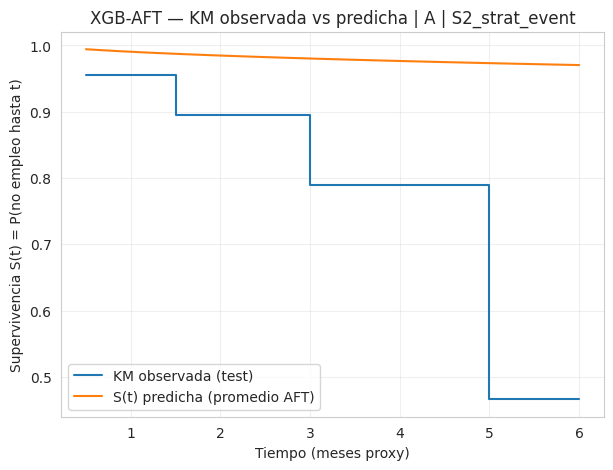

✅ Guardada: /content/artifacts_xgb/plots_xgb/KM_vs_Pred_XGB_A_S2_strat_event.png


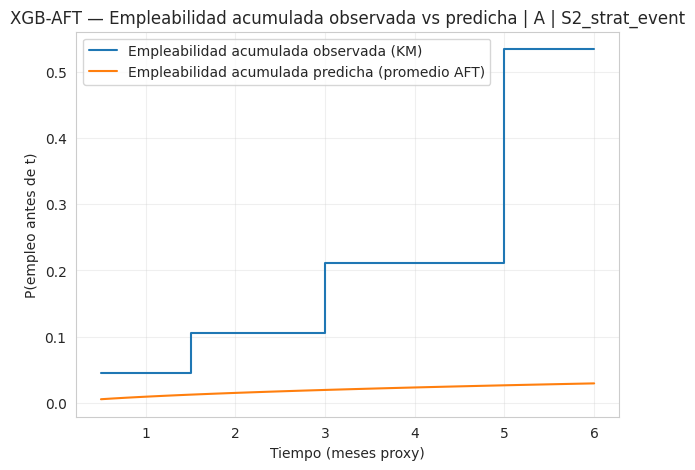

✅ Guardada: /content/artifacts_xgb/plots_xgb/Employability_Cum_XGB_A_S2_strat_event.png

📌 Nota sobre 'destransformar':
- Para curvas S(t) y 1-S(t) NO necesitas destransformar.
- 'Destransformar' aplica si quieres un tiempo puntual predicho (mediana/p90), no para la curva.


In [112]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sksurv.nonparametric import kaplan_meier_estimator
from scipy.special import erf # Importar erf desde scipy.special

# =========================
# CONFIG
# =========================
ART_XGB_DIR = "/content/artifacts_xgb"
REF_DIR = os.path.join(ART_XGB_DIR, "refined_best")
PLOT_DIR = os.path.join(ART_XGB_DIR, "plots_xgb")
os.makedirs(PLOT_DIR, exist_ok=True)

# =========================
# helpers (proxy time + structured y)
# =========================
def make_t_mid(y_df):
    lo = y_df["T_Lower"].astype(float).values
    up = y_df["T_Upper"].astype(float).replace(np.inf, np.nan).values
    cap = np.nanmax(up) if np.isfinite(np.nanmax(up)) else np.nanmax(lo)
    up_cap = np.where(np.isfinite(y_df["T_Upper"].astype(float).values),
                      y_df["T_Upper"].astype(float).values, cap)
    return (lo + up_cap) / 2.0

def structured_y_from_mid(y_df):
    t_mid = make_t_mid(y_df)
    e = y_df["Event"].astype(int).values.astype(bool)
    return np.array(list(zip(e, t_mid)), dtype=[("event", "?"), ("time", "<f8")])

# =========================
# AFT survival: S(t) = P(T > t)
# log(T) = mu + sigma * Z
# => S(t) = 1 - F((log t - mu)/sigma)
# distribuciones típicas: normal o logistic
# =========================
def _sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def aft_survival_matrix(mu, times, dist="normal", scale=1.0):
    """
    mu: (n,) predicción xgb (AFT location)
    times: (m,) tiempos > 0
    retorna S: (n,m)
    """
    mu = np.asarray(mu).reshape(-1, 1)
    t = np.asarray(times).reshape(1, -1)

    # evitar log(0)
    t = np.maximum(t, 1e-9)
    z = (np.log(t) - mu) / float(scale)

    if dist.lower() in ["normal", "gaussian"]:
        # Phi(z) usando erf
        Phi = 0.5 * (1.0 + erf(z / np.sqrt(2.0))) # Usar scipy.special.erf
        S = 1.0 - Phi
    elif dist.lower() in ["logistic"]:
        F = _sigmoid(z)
        S = 1.0 - F
    else:
        raise ValueError(f"Distribución AFT no soportada aquí: {dist}. Usa 'normal' o 'logistic'.")

    # clip numérico
    return np.clip(S, 1e-6, 1.0)

# =========================
# 1) elegir mejor escenario XGB desde tu results (ya guardado)
# =========================
results_path = os.path.join(ART_XGB_DIR, "results_xgb_aft_random_cv.csv")
results_xgb = pd.read_csv(results_path)

# usa test_cindex si existe; sino cindex_test
score_col = "test_cindex" if "test_cindex" in results_xgb.columns else "cindex_test"
best_row = results_xgb.sort_values(score_col, ascending=False).iloc[0]
best_ds = best_row["dataset"]
best_split = best_row["split"]
print("✅ Mejor XGB-AFT:", best_ds, best_split, "|", score_col, "=", float(best_row[score_col]))

# =========================
# 2) cargar booster refinado (si no está en memoria)
# =========================
ref_model_path = os.path.join(REF_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}.json")
if not os.path.exists(ref_model_path):
    raise FileNotFoundError(
        f"No encuentro el refinado: {ref_model_path}\n"
        f"(Asegúrate de haber ejecutado la celda que guarda el refinado.)"
    )

booster = xgb.Booster()
booster.load_model(ref_model_path)

# cargar meta para saber dist/scale
meta_path = os.path.join(REF_DIR, f"xgb_aft_refined_best_{best_ds}_{best_split}_meta.json")
with open(meta_path, "r", encoding="utf-8") as f:
    meta = json.load(f)

params_used = meta.get("params_used", {})
dist = params_used.get("aft_loss_distribution", "normal")
scale = float(params_used.get("aft_loss_distribution_scale", 1.0))

print("AFT dist:", dist, "| scale:", scale)

# =========================
# 3) obtener test externo del split (¡desde splits!)
# =========================
if best_ds == "A":
    X_use, y_use, splits_use = X_A, y_A, splits_A
else:
    X_use, y_use, splits_use = X_B, y_B, splits_B

tr, te = splits_use[best_split]
Xte = X_use.iloc[te].reset_index(drop=True)
yte = y_use.iloc[te].reset_index(drop=True)

yte_s = structured_y_from_mid(yte)

# KM observada en test
t_km, s_km = kaplan_meier_estimator(yte_s["event"], yte_s["time"])

# =========================
# 4) curva predicha: promedio de S(t)
# =========================
# rango de tiempos válido (importante: >0)
t_min = float(np.min(yte_s["time"]))
t_max = float(np.max(yte_s["time"]))

# genera tiempos dentro del rango de seguimiento del test (estricto: < t_max)
times = np.linspace(max(1e-3, t_min), np.nextafter(t_max, 0), 40)

mu_te = booster.predict(xgb.DMatrix(Xte))
S_te = aft_survival_matrix(mu_te, times, dist=dist, scale=scale)
S_mean = S_te.mean(axis=0)

# =========================
# (G1) KM Observada vs Predicha
# =========================
plt.figure(figsize=(7,5))
plt.step(t_km, s_km, where="post", label="KM observada (test)")
plt.plot(times, S_mean, label="S(t) predicha (promedio AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("Supervivencia S(t) = P(no empleo hasta t)")
plt.title(f"XGB-AFT — KM observada vs predicha | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()

out1 = os.path.join(PLOT_DIR, f"KM_vs_Pred_XGB_{best_ds}_{best_split}.png")
plt.savefig(out1, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out1)

# =========================
# (G2) Empleabilidad acumulada: 1 - S(t)
# =========================
plt.figure(figsize=(7,5))
plt.step(t_km, 1.0 - s_km, where="post", label="Empleabilidad acumulada observada (KM)")
plt.plot(times, 1.0 - S_mean, label="Empleabilidad acumulada predicha (promedio AFT)")
plt.xlabel("Tiempo (meses proxy)")
plt.ylabel("P(empleo antes de t)")
plt.title(f"XGB-AFT — Empleabilidad acumulada observada vs predicha | {best_ds} | {best_split}")
plt.grid(True, alpha=0.3)
plt.legend()

out2 = os.path.join(PLOT_DIR, f"Employability_Cum_XGB_{best_ds}_{best_split}.png")
plt.savefig(out2, dpi=160, bbox_inches="tight")
plt.show()
print("✅ Guardada:", out2)

print("\n📌 Nota sobre 'destransformar':")
print("- Para curvas S(t) y 1-S(t) NO necesitas destransformar.")
print("- 'Destransformar' aplica si quieres un tiempo puntual predicho (mediana/p90), no para la curva.")